# Capstone: Analyzing and Predicting Pitching Data

#### Donovan Brady

#### Booz Allen + GA: Data Science Foundations

Outline 
1. Problem Statement
2. Obtaining Data
3. Experimental Data Analysis
4. Machine Learning
5. Predicting Future Prospects
6. Conclusion

# 1. Problem Statement

Baseball is a statistics driven game, but there are often parts of the game people would argue statistics don't tell the whole story. When evaluating up-and-coming pitchers, scouts often have little statistical information to go off of. Because young pitchers face a much wider variety of talent, scouts can really only go off of how well they think a pitcher will do against a major league hitters. Rather than looking at their performance history, they have to look at their "stuff": What they throw, how accurate they are, etc.

My goal is to take data on pitchers that can be obtained wihtout the presence of a batter at the plate (with a few exceptions like walks per 9 innings). That way, we can see if we can determine if a pitcher will be successful in the major leagues without a need for them to face a single major league batter.

We want to reject the hypothesis that we need historical performance data (like how many runs does the pitcher give up) to determine if the pitcher will be successful in the future. This is done by proving that we can fit a model to some degree of accuracy that will predict a pitcher's successfulness based on the features chosen.

### Load Relevant Libraries to Start (may load more later)

In [234]:
#pip install pybaseball

In [235]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


#pybaseball is the library used to download data
from pybaseball import pitching_stats #gets the general stats for major league pitchers
from pybaseball.statcast_pitcher_spin import statcast_pitcher_spin #gets the spin of pitches thrown by a pitcher over a set time period
from pybaseball.playerid_lookup import playerid_lookup #looks up the id of a pitcher using a pitcher's name
from pybaseball.playerid_lookup import playerid_reverse_lookup

# 2. Obtaining Data

### Refer to the notebook "Get data for unit-4_project" for the methodology on how I obtained this data. In short, the data comes from three sources: Fangraphs.com, BaseballSavant (Statcast data), and Baseball Reference (bibliographical data). I merged these two datasets because I wanted information from both (specifically features that you could get by doing a scouting report). I also parsed out the information I did not need (the Fangraphs data had over 300 columns, and I only took a few). After downloading the data, I wrote it into a csv file so I don't have to download a bunch of data every time I open this notebook.

### Read data from mlb_pitcher_data.csv

In [236]:
pitching_data = pd.read_csv('mlb_pitcher_data.csv')

## Details about the Data

Again, refer to the "Get data for unit-4_project" notebook for how I created this .csv file. 

In [397]:
pitching_data

,Unnamed: 0,last_name,first_name,mlbam_id,ff_avg_speed,si_avg_speed,fc_avg_speed,sl_avg_speed,ch_avg_speed,cu_avg_speed,...,Fav_pitch_cu,Fav_pitch_fc,Fav_pitch_ff,Fav_pitch_si,Fav_pitch_sl,Fav_pitch_2_ch,Fav_pitch_2_cu,Fav_pitch_2_ff,Fav_pitch_2_si,Fav_pitch_2_sl
0,0,Clase,Emmanuel,661403,100.7,NaN,100.2,91.9,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1
1,1,Clase,Emmanuel,661403,99.5,NaN,99.2,90.5,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1
2,2,Hicks,Jordan,663855,100.5,99.2,87.2,83.5,90.2,NaN,...,0,0,0,1,0,0,0,0,0,0
3,3,Hicks,Jordan,663855,100.9,101.1,NaN,87.0,91.0,NaN,...,0,0,0,1,0,0,0,0,0,1
4,4,Hicks,Jordan,663855,100.9,100.5,NaN,86.2,NaN,NaN,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,2278,Hart,Donnie,643354,NaN,87.7,NaN,76.1,80.6,NaN,...,0,0,0,1,0,0,0,0,0,1
2279,2279,Bergman,Christian,548357,NaN,88.5,NaN,85.3,78.3,76.7,...,0,0,0,1,0,1,0,0,0,0
2280,2280,Solís,Sammy,519301,NaN,93.3,NaN,NaN,85.3,78.1,...,0,0,0,1,0,0,1,0,0,0
2281,2281,Rzepczynski,Marc,519240,NaN,91.9,NaN,84.1,86.2,NaN,...,0,0,0,1,0,0,0,0,0,1


In [238]:
pitching_data.columns #check to see the names of each column

Index(['Unnamed: 0', 'last_name', ' first_name', 'mlbam_id', 'ff_avg_speed',
       'si_avg_speed', 'fc_avg_speed', 'sl_avg_speed', 'ch_avg_speed',
       'cu_avg_speed', 'fs_avg_speed', 'ff_avg_spin', 'si_avg_spin',
       'fc_avg_spin', 'sl_avg_spin', 'ch_avg_spin', 'cu_avg_spin',
       'fs_avg_spin', 'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs',
       'Season', 'F-Strike%', 'BB/9', 'Age', 'WAR', 'K/9', 'ERA', 'Fav_pitch',
       'Fav_pitch_2', 'Num_pitches', 'throws', 'weight', 'height'],
      dtype='object')

Pitching_data contains information about Major League Pitchers from the years 2018-2021. The information includes their first name, their last name, and their mlbam id (unique identifier). 

For each pitcher, there is information on the types of pitches they throw. There are seven different kinds of pitches:
1. __Fastball__ (ff) - ball thrown straight as possible to maximize speed
2. __Sinker__ (si) - ball thrown fast, but with some downward movement
3. __Cutter__ (fc) - ball thrown fast, but with some sideways movement
4. __Slider__ (sl) - ball meant to move away from the strikezone horizontally
5. __Changeup__ (ch) - ball meant to go slower than a fastball (decieving the batter)
6. __Curveball__ (cu) - ball meant to move away from the strikezone both vertically (and horizontall)
7. __Splitter__ (fs) - halfway between a changeup and a fastball, but has a lot of downward movement

The aspects of these pitches that are recorded in the data are its average speed (pitch_avg_speed), its average spin (pitch_avg_spin), and the percentage of the time it is thrown by that entry's pitcher (n_pitch).

__Speed__ is recorded in miles per hour and is how fast the pitch moves.

__Spin__ is the rotations per minute of the ball, captured via advanced techniques. Spin is often how a pitch is able to move up, horizontally, or downwards. (Although a knuckleball, which is ignored intentianally because of how much of an outlier it is, has no spin at all)

The __percentage__, represented by n_(pitch), shows how often a pitch is thrown within that pitcher's arsenal. If n_ff = 0.5, then the pitcher throws a fastball 50% of the time.



__Assumption__ An assumption was made to include the pitcher's data for a single season, rather over multiple. This is because many pitcher's change their arsenal over the years. For example, pitcher's start to throw slower as they age. This means, they may have been really successful in their early years, but very unsuccessful later. If I were to take the pitcher's stats over their career, I would not understand why they were good one year, but not so good another.

Therefore, each entry has a season. This means a pitcher can show up multiple times in the data, but not have the same season.

__Other Metrics include F-Strike%, BB/9, Age, WAR, K/9, and ERA.__


__F-Strike%__ is the percentage that a pitcher throws a strike on the first pitch of an at-bat.

__BB/9__ is the amount of walks given up per 9 innings.

__Age__ is a pitcher's age in years (probably won't use this).

__WAR__ stands for wins above replacement. It is a number representing the amount of wins a pitcher generates over the standard replacement player. A replacement player would be someone who would be the understudy a team would bring in if, for example, every pitcher got hurt (either a free agent or minor leaguer). The metric is complex and not perfect, but it gives a good approximation of the amount of value a pitcher provides for their team.

__K/9__ is the amount of strikeouts per 9 innings.

__ERA__ is a pitcher's earned run average. It is the amount of runs they give up per 9 innings that weren't caused by an error on the field. Those runs are theoretically "the pitcher's fault". This is not a perfect stat as ERA is dependent on a ton of uncontrollable factors on the pitcher's part. This could also be a metric for value.

(Might add more metrics later)



__Biographical information such as throwing arm, height, and weight__

__Throws__ is the hand which the pitcher throws (right or left). __Height__ is the pitcher's height in cm. __Weight__ is the pitcher's weight in pounds.

__Finally, there is some information I featured engineered (see other notebook)__

Fav_pitch is the pitcher's most thrown pitch, while Fav_pitch_2 is the pitcher's second favorite pitch.

Num_pitches represents the number of pitches a pitcher throws.

In [239]:
pitching_data.describe() #throw a describe in there

,Unnamed: 0,mlbam_id,ff_avg_speed,si_avg_speed,fc_avg_speed,sl_avg_speed,ch_avg_speed,cu_avg_speed,fs_avg_speed,ff_avg_spin,...,Season,F-Strike%,BB/9,Age,WAR,K/9,ERA,Num_pitches,weight,height
count,2283.000000,2283.000000,2184.000000,1585.000000,639.000000,1773.000000,1832.000000,1495.000000,139.000000,2184.000000,...,2283.000000,2283.000000,2283.000000,2283.000000,2283.000000,2283.000000,2283.000000,2283.000000,2283.000000,2283.000000
mean,1141.000000,586150.058257,93.220559,92.709338,88.495931,84.291201,85.350928,78.593779,85.779856,2262.688187,...,2019.493649,0.598418,3.687328,28.082786,0.629742,8.873815,4.615703,4.091984,215.279457,74.605782
std,659.189654,67265.653063,2.511117,2.716788,2.694383,3.105542,3.234613,3.442439,2.852971,155.630161,...,1.149374,0.054244,1.508571,3.597116,1.161358,2.243634,1.933819,0.960819,19.640120,2.045410
min,0.000000,112526.000000,80.600000,78.900000,78.800000,70.000000,63.000000,59.400000,76.800000,1769.000000,...,2018.000000,0.359000,0.340000,19.000000,-1.400000,1.710000,0.000000,2.000000,155.000000,67.000000
25%,570.500000,543272.000000,91.700000,91.000000,86.700000,82.400000,83.600000,76.500000,84.100000,2158.000000,...,2018.000000,0.565000,2.660000,25.000000,-0.100000,7.330000,3.330000,3.000000,202.000000,73.000000
50%,1141.000000,605218.000000,93.400000,92.800000,88.300000,84.600000,85.700000,78.800000,86.100000,2262.000000,...,2019.000000,0.600000,3.450000,28.000000,0.300000,8.710000,4.340000,4.000000,215.000000,75.000000
75%,1711.500000,641816.000000,94.800000,94.400000,90.200000,86.500000,87.500000,81.000000,87.850000,2366.000000,...,2021.000000,0.636000,4.500000,30.000000,0.900000,10.265000,5.605000,5.000000,225.000000,76.000000
max,2282.000000,685503.000000,100.900000,101.100000,100.200000,92.500000,95.700000,87.200000,92.200000,2891.000000,...,2021.000000,0.759000,15.260000,45.000000,9.000000,17.670000,18.260000,7.000000,285.000000,82.000000


In [240]:
#lot's of null values with speed and spin
#will have to think of solution for those
pitching_data.isnull().sum()

Unnamed: 0         0
last_name          0
 first_name        0
mlbam_id           0
ff_avg_speed      99
si_avg_speed     698
fc_avg_speed    1644
sl_avg_speed     510
ch_avg_speed     451
cu_avg_speed     788
fs_avg_speed    2144
ff_avg_spin       99
si_avg_spin      699
fc_avg_spin     1644
sl_avg_spin      510
ch_avg_spin      451
cu_avg_spin      790
fs_avg_spin     2144
n_ff               0
n_si               0
n_fc               0
n_sl               0
n_ch               0
n_cu               0
n_fs               0
Season             0
F-Strike%          0
BB/9               0
Age                0
WAR                0
K/9                0
ERA                0
Fav_pitch          0
Fav_pitch_2        0
Num_pitches        0
throws             0
weight             0
height             0
dtype: int64

# 3. EDA 

In [241]:
pitching_data.head()

,Unnamed: 0,last_name,first_name,mlbam_id,ff_avg_speed,si_avg_speed,fc_avg_speed,sl_avg_speed,ch_avg_speed,cu_avg_speed,...,Age,WAR,K/9,ERA,Fav_pitch,Fav_pitch_2,Num_pitches,throws,weight,height
0,0,Clase,Emmanuel,661403,100.7,NaN,100.2,91.9,NaN,NaN,...,23,2.2,9.56,1.29,fc,sl,3,R,206.0,74.0
1,1,Clase,Emmanuel,661403,99.5,NaN,99.2,90.5,NaN,NaN,...,21,0.4,8.10,2.31,fc,sl,3,R,206.0,74.0
2,2,Hicks,Jordan,663855,100.5,99.2,87.2,83.5,90.2,NaN,...,24,0.0,9.00,5.40,si,fc,5,R,220.0,74.0
3,3,Hicks,Jordan,663855,100.9,101.1,NaN,87.0,91.0,NaN,...,22,0.5,9.73,3.14,si,sl,3,R,220.0,74.0
4,4,Hicks,Jordan,663855,100.9,100.5,NaN,86.2,NaN,NaN,...,21,0.5,8.11,3.59,si,sl,3,R,220.0,74.0


In [242]:
#in case if I want to look at a single season
pitching_data_2021 = pitching_data[pitching_data['Season'] == 2021]

## WAR (Wins Above Replacement)

### The response variable in this project will be WAR

To measure the successfulness of a major league pitcher we look at WAR (Wins above Replacement). 

At its most basic level, pitching WAR calculation requires only overall Runs Allowed (both earned and unearned) and Innings Pitched. Fangraphs WAR (the one used here) uses FIP (Fielding Independent Pitching) which, for the purpose of simplifying, represents the amount of runs a pitcher gives up. Fangraphs also considers the ballpark being played at and the amount of innings pitched. This is not a simple calculation (especially for pitchers) so refer here for descriptions and links for further details https://library.fangraphs.com/misc/war/


Simply, WAR is an attempt by the sabermetric baseball community to summarize a player’s total contributions to their team in one statistic. While it is not the be-all and end-all for pitchers, WAR can give a good approximation of the value of a pitcher. 

For example: Fangraphs provides good rule-of-thumb chart to assess the meaning of WAR.

- Scrub	0-1 WAR
- Role Player	1-2 WAR
- Solid Starter	2-3 WAR
- Good Player	3-4 WAR
- All-Star	4-5 WAR
- Superstar	5-6 WAR
- MVP	6+ WAR

A higher WAR represents a pitcher's ability to win games for their team. A higher WAR means success, while a low or negative WAR indicates a pitcher was not successful for their team.

That being said, baseball is a very complex game and summarizing everything into one number can't be done without losing fine details that really help define what a player is about.


Let's look at WAR

In [243]:
pitching_data['WAR'].describe()

count    2283.000000
mean        0.629742
std         1.161358
min        -1.400000
25%        -0.100000
50%         0.300000
75%         0.900000
max         9.000000
Name: WAR, dtype: float64

Two things stick out to me. 
1. The standard deviation is greater than the mean implying WAR is heavily skewed.
2. 75% of pitchers have a WAR under ~1. According to Fangraphs, 3/4 of mlb pitchers are scrubs? May need to reavaluate what scrub means

Let's look at a graph.

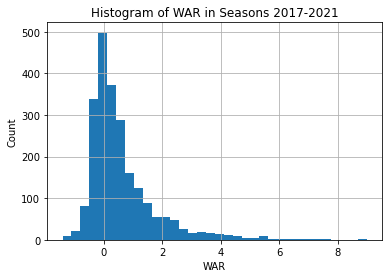

In [244]:
#get histogram of WAR
pitching_data['WAR'].hist(bins='scott')
plt.xlabel('WAR')
plt.ylabel('Count')
plt.title('Histogram of WAR in Seasons 2017-2021')
plt.show()

We see above that the above histogram is positively skewed. This makes sense as the All-star caliber pitchers are in a league of their own, while most of the pitchers in the league are competing at similar levels. We also see that many pitcher's have negative WAR, meaning loosely that they are worse than their replacement.

While Fangraphs describes a scrub pitcher as between a 0-1 WAR, I'm going to define an unsuccessful pitcher with a __0 or negative WAR__. This is because, looking at the histogram above, most major league pitchers have a WAR between 0-1. A large amount of the best pitchers in the world play in the MLB, so to be playing as well as most of your peers warrents a success from my perspective. It is only when there is someone not in the major leagues who can take your place and do a better job is when I say that you have been unsuccessful. 

__Assumption__: A successful pitcher has a WAR > 0. An unsuccessful pitcher has a WAR <= 0. This was arbitrarly chosen by myself as the determination of whether someone is successful or not is wholly subjective. Therefore, in no way whatsoever is this objective. In fact, I am certain there is going to be a great pitcher who finds themself on the wrong side of this assumption. However, this is a conservative assumption. I believe setting a WAR <= 0, is more than enough room for a successful pitcher to put up sub-par or unlucky numbers but still make the cut (i.e. more sub-par pitchers will be considered successful than above-par pitchers successful).


In [245]:
print('number of unsuccessful pitchers:', pitching_data[pitching_data['WAR']<=0].shape[0])

number of unsuccessful pitchers: 785


In [246]:
print('number of successful pitchers:', pitching_data[pitching_data['WAR']>0].shape[0])

number of successful pitchers: 1498


Since I want to answer the simple question, "Will this pitcher be successful", let's create a binary feature that states the pitcher is successful or unsucessful. This column called "successful" will represent two different classes, which turns this problem into a classification problem if we use "successful" as the response variable instead of "WAR"

In [247]:
#Let's make a new column called "successful" that is a 1 if a pitcher has a successful season (postive WAR), 0 otherwise
def success_of_pitcher(WAR):
    if WAR > 0:
        return 1
    else:
        return 0
    
pitching_data['successful'] = pitching_data['WAR'].apply(success_of_pitcher)
pitching_data.head()

,Unnamed: 0,last_name,first_name,mlbam_id,ff_avg_speed,si_avg_speed,fc_avg_speed,sl_avg_speed,ch_avg_speed,cu_avg_speed,...,WAR,K/9,ERA,Fav_pitch,Fav_pitch_2,Num_pitches,throws,weight,height,successful
0,0,Clase,Emmanuel,661403,100.7,NaN,100.2,91.9,NaN,NaN,...,2.2,9.56,1.29,fc,sl,3,R,206.0,74.0,1
1,1,Clase,Emmanuel,661403,99.5,NaN,99.2,90.5,NaN,NaN,...,0.4,8.10,2.31,fc,sl,3,R,206.0,74.0,1
2,2,Hicks,Jordan,663855,100.5,99.2,87.2,83.5,90.2,NaN,...,0.0,9.00,5.40,si,fc,5,R,220.0,74.0,0
3,3,Hicks,Jordan,663855,100.9,101.1,NaN,87.0,91.0,NaN,...,0.5,9.73,3.14,si,sl,3,R,220.0,74.0,1
4,4,Hicks,Jordan,663855,100.9,100.5,NaN,86.2,NaN,NaN,...,0.5,8.11,3.59,si,sl,3,R,220.0,74.0,1


In short, if this is a classification problem __Response Variable = successful__

If this is a predicting a continuous value problem (regression): __Response Variable = WAR__

However, both problems are using WAR as something we want to predict.

## Feature Selection
For this next portion, I try to justify why we may consider using certain features in the machine learning model. A lot of this is checking for colinearity between features to remove unecessary data and using knowledge about the game of baseball.

## Pitch Speed and Spin

We have information about the velocity and spin (number of rotations per minute) for every pitch thrown by each pitcher. However, is all of this information "relevant" to our model. We do not want to put highly correlated feautres in our model in predicting WAR. Pitchers who throw a high speed fastball most likely throws a higher speed curveball than a pitcher who throws a slow fastball. 

### Pitch Speeds

Theoretically, pitchers who throw hard are more difficult to hit. That is because the batter is given less time to swing their bat, and therefore have a more slim margin error. That is why pitchers who hit triple digits (100 mph) are highly valued in baseball since they can overpower the opponent with their fastest pitch. However, pitch speed is only one element of the puzzle. 

While it is obvious to consider a pitcher's fastest pitch (usually a fastball or sinker), should we consider the speeds of lower pitches. Let's look at the correlations, as we do not want our features to be highly correlated when fitting the model.

Below is fastball versus sinker, fastball versus curveball.

              ff_avg_speed  si_avg_speed
ff_avg_speed      1.000000      0.946932
si_avg_speed      0.946932      1.000000


              ff_avg_speed  cu_avg_speed
ff_avg_speed      1.000000      0.601944
cu_avg_speed      0.601944      1.000000


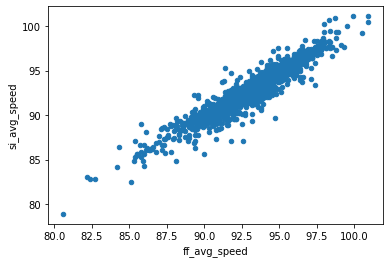

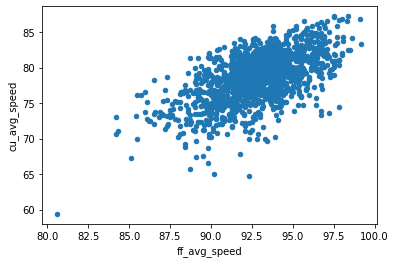

In [248]:
# fastball vs sinker (speeds)
pitching_data.plot(kind='scatter', x = 'ff_avg_speed', y='si_avg_speed');
print(pitching_data[['ff_avg_speed', 'si_avg_speed']].corr())

#fastball vs curveball (speeds)
print('\n')
pitching_data.plot(kind='scatter', x = 'ff_avg_speed', y='cu_avg_speed');
print(pitching_data[['ff_avg_speed', 'cu_avg_speed']].corr())

Fastballs and sinkers are extremely highly correlated in terms of speed, so we should consider these the same speed wise.

Fastball and curveball speeds are moderately correlated. However, a curveball's speed is rarely what makes this pitch useful, so I am considering not using it.

Let's look at the heatmap if there are any other findings.

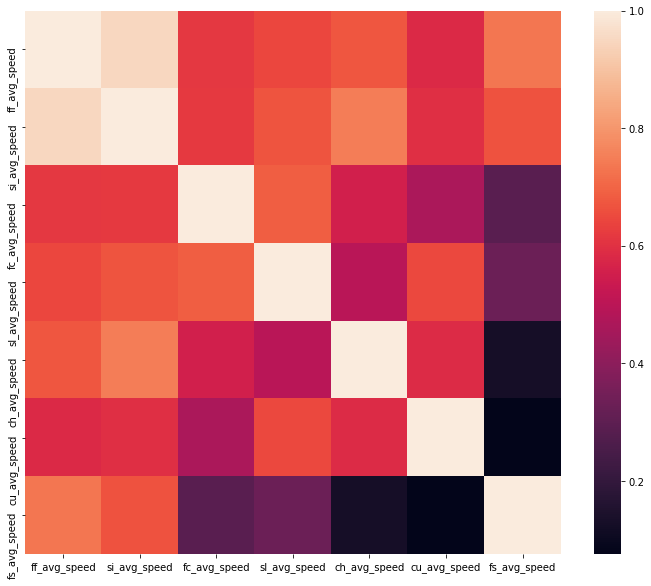

In [249]:
# plot correlation heatmap using seaborne
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(pitching_data_2021[['ff_avg_speed', 'si_avg_speed',
       'fc_avg_speed', 'sl_avg_speed', 'ch_avg_speed', 'cu_avg_speed',
       'fs_avg_speed']].corr(), ax=ax);

__Takeaway__: Because the speeds of each pitch are highly to moderately correlated, I don't think it is worth considering more than one feature when measuring a pitcher's speed. Really, velocity is important to pitches such as the fastball or sinker that are thrown to get batters to swing late.

Therefore we may consider just the pitcher's __fastest pitch__ as a measure of a pitcher's speed.

Typically, a pitcher's fastest pitch is either their fastball, sinker, or cutter. Let's create a new column called average fastest speed that contains the average speed of the pitcher's fastest pitch

The function below assumes that the fastball is the fastest pitch, followed by sinker, then cutter (in theory this should be the case). However, not all pitchers throw a fastball, so a pitcher's fastest pitch may be a sinker or a cutter. The logic is shown in the function.

In [250]:
# Function: get average of fastest speed
# Parameters: Pitching data
# Purpose: Stores the average velocity of a pitcher's fastest pitch into the avg_fastest_speed column.
#          This is done by assuming the fastball is the fastest pitch, but if a pitcher doesn't throw a fastball
#          then it is a sinker. If a pitcher doesn't throw a fastball or a sinker, then the pitch is a cutter.

def get_avg_fastest_speed(pitching_df):
    for i in range(pitching_df.shape[0]):
        
        # if a pitcher throws a fastball, that is the pitcher's fastest pitch
        if math.isnan(pitching_df['ff_avg_speed'].loc[i]) == False:
            pitching_df['avg_fastest_speed'].loc[i] = pitching_df['ff_avg_speed'].loc[i]
        
        # if a pitcher doesn't throw a fastball but throws a sinker, then the fastest pitch is a sinker
        elif math.isnan(pitching_df['si_avg_speed'].loc[i]) == False:
            pitching_df['avg_fastest_speed'].loc[i] = pitching_df['si_avg_speed'].loc[i]
        
        # if a pitcher doesn't throw a fastball or a sinker, then it must be a cutter
        else:
            pitching_df['avg_fastest_speed'].loc[i] = pitching_df['fc_avg_speed'].loc[i]
    
    return pitching_df

Let's create this new "fastest pitch" column.

In [251]:
# create new column called avg_fastest_speed
pitching_data['avg_fastest_speed'] = 0

# run the function in the cell above to fill values in avg_fastest_speed
pitching_data = get_avg_fastest_speed(pitching_data.copy())



C:\Users\605089\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Check if we are missing any pitcher's (a pitcher who doesn't throw a fastball, sinker, or cutter)

In [252]:
# check if we are missing a pitcher's fastest pitch
pitching_data['avg_fastest_speed'].isnull().sum()

0

Compare to WAR

,avg_fastest_speed,WAR
avg_fastest_speed,1.000000,0.112899
WAR,0.112899,1.000000


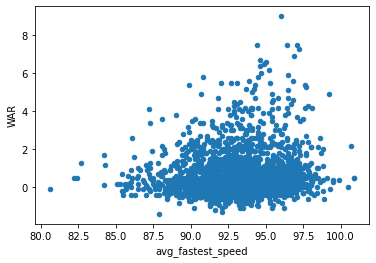

In [253]:
#graph the fastest speed of pitchers compared to their WAR to see if we could use it as a feature

pitching_data.plot(kind='scatter', x='avg_fastest_speed', y='WAR')
pitching_data[['avg_fastest_speed', 'WAR']].corr()

Speed has a correlation with WAR, but it is farily low, which means that speed is only one piece of the puzzle in a pitcher's success.

### Pitching Spin
(This is a long section. To summarize the results of this EDA, I end up creating a new feature that averages the spin of each pitch called 'avg_spin'. However, 'avg_spin' excludes changeups and splitters because I find out the spin on those pitches are outliers compared to the others)

A pitch's spin is the rotations per minute of the ball thrown. This is a more advanced measurement that has only come in the recent decade. In recent years, Pitcher's have been using sticky substances on their hands to artificially increase the spin rate of their pitches as a method to increase their odds of success (current hot topic in baseball). 

Let's see if we need to combine spin into one feature similar to speed based on if they are colinear or not.

             ff_avg_spin  si_avg_spin
ff_avg_spin     1.000000     0.823161
si_avg_spin     0.823161     1.000000


             ff_avg_spin  cu_avg_spin
ff_avg_spin     1.000000     0.477528
cu_avg_spin     0.477528     1.000000


             ff_avg_spin  ch_avg_spin
ff_avg_spin     1.000000     0.267582
ch_avg_spin     0.267582     1.000000


             ff_avg_spin  fs_avg_spin
ff_avg_spin     1.000000     0.223343
fs_avg_spin     0.223343     1.000000


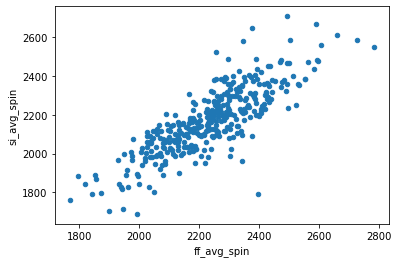

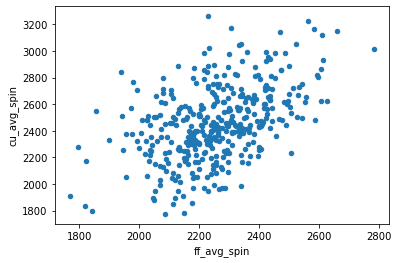

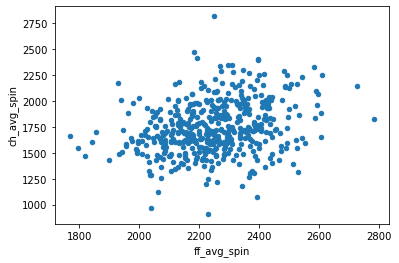

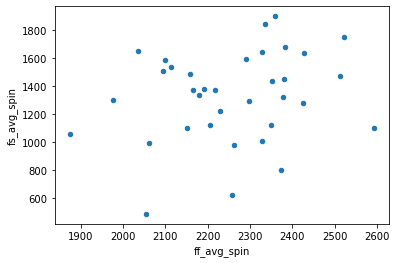

In [254]:
# fastball vs sinker (spin)
pitching_data_2021.plot(kind='scatter', x = 'ff_avg_spin', y='si_avg_spin');
print(pitching_data_2021[['ff_avg_spin', 'si_avg_spin']].corr())

print('\n')

# fastball vs curveball (spin)
pitching_data_2021.plot(kind='scatter', x = 'ff_avg_spin', y='cu_avg_spin');
print(pitching_data_2021[['ff_avg_spin', 'cu_avg_spin']].corr())

print('\n')

# fastball versus changeup (spin)
pitching_data_2021.plot(kind='scatter', x = 'ff_avg_spin', y='ch_avg_spin');
print(pitching_data_2021[['ff_avg_spin', 'ch_avg_spin']].corr())

print('\n')

#fastball vs cutter (spin)
pitching_data_2021.plot(kind='scatter', x = 'ff_avg_spin', y='fs_avg_spin');
print(pitching_data_2021[['ff_avg_spin', 'fs_avg_spin']].corr())

1. Fastball and sinker are very similar in their average spin.
2. Fastball and curveballs are moderately correlated in their spin. 
3. Fastballs and changeups are weakly correlated in their spin. This is interesting as changeups seem to be the most random in their spin as a function of the spin of that same pitcher's fastball. This is most likely due to the fact that a changeup is meant to be a pitch to decieve a batter in solely its speed and not its movement.
4. Splitters are less correlated. However, the points are quite sparse, so it would be interesting to see the restuls with more data points. The splitter is similar to the changeup in its use, so I expect a similar result to the changeup.

Let's look at a heatmap.

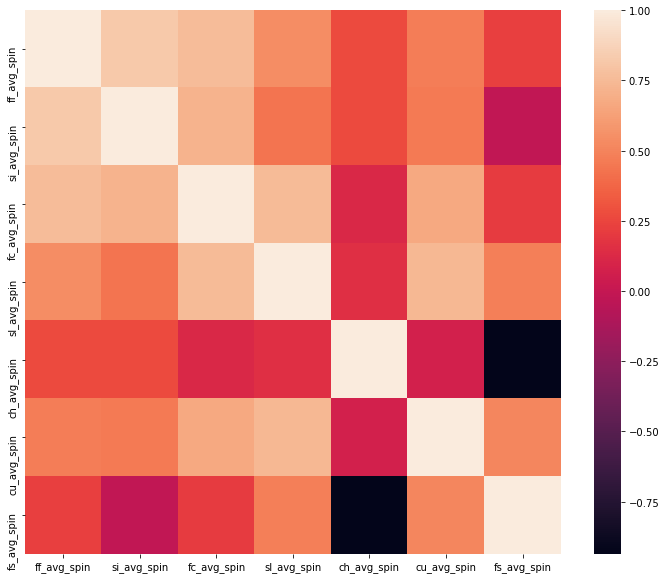

In [255]:
#seaborne heatmap of spin
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(pitching_data_2021[['ff_avg_spin', 'si_avg_spin',
       'fc_avg_spin', 'sl_avg_spin', 'ch_avg_spin', 'cu_avg_spin', 'fs_avg_spin']].corr(), ax=ax);

__Looking above__ there seem to be _three_ groups:
1. Fastballs (ff, si, fc) are highly correlated in terms of spin
2. Breaking balls (cu, sl) are moderately correlated, but curveball seems to align better with the slider than fastballs.
3. Changeups and splitters (ch, fs) are the odd ones out with a negative correlation. Changeups seem to be the least correlated to fastballs.

To analyze further, let' seperate each pitch and graph via a box plot.

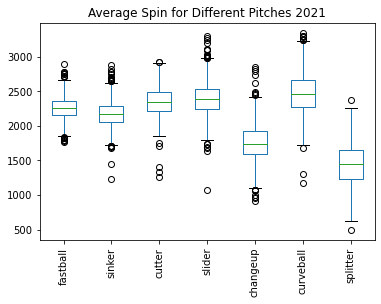

In [256]:
fig, ax = plt.subplots()

pitch_types = ['fastball', 'sinker', 'cutter', 'slider', 'changeup', 'curveball', 'splitter']

pitching_data[['ff_avg_spin', 'si_avg_spin',
       'fc_avg_spin', 'sl_avg_spin', 'ch_avg_spin', 'cu_avg_spin',
       'fs_avg_spin']].plot(kind='box', rot=90, ax = ax);

ax.set_xticklabels(pitch_types)
plt.title('Average Spin for Different Pitches 2021');

1. Group 1 (fastball, sinker, and cutter) seem to have similar spins.
2. Group 2 (breaking balls) generally the greatest amount of spin (slider and curveball)
3. Group 3 (changeups and splitters) have by far the lowest spin

__Idea__: What if we seperate spin by these three groups. A spin for fastballs, a spin for breaking balls, and a spin for changeups.

Based on the above heatmap, I am fairly confident in combining the fastball, sinker, and cutter into one fastball spin feature (because they are highly correlated and have similar values of spin). 

In [257]:
#create new column avg_fastball_spin that contains the mean of fastball spin, sinker spin, and cutter spin
pitching_data['avg_fastball_spin'] = round(pitching_data[['ff_avg_spin', 'si_avg_spin', 'fc_avg_spin']].mean(axis=1), 1)

However, let's look at the breaking ball, curveball's versus sliders.

,sl_avg_spin,cu_avg_spin
sl_avg_spin,1.000000,0.704514
cu_avg_spin,0.704514,1.000000


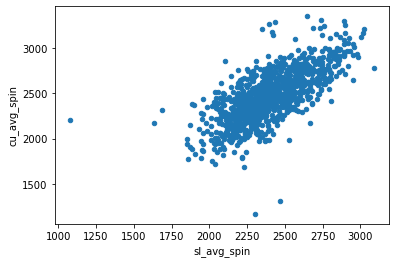

In [258]:
#slider vs curveball (spin)
pitching_data.plot(kind='scatter', x = 'sl_avg_spin', y='cu_avg_spin');
pitching_data[['sl_avg_spin', 'cu_avg_spin']].corr()

Slider's spin and curveball's spin look very correlated. The box plot shows that they have similar values in spin, so I am confident in combining these two into a breaking ball spin feature.

In [259]:
# create new column called avg_breaking_spin that contains the mean of slider and curveball spins
pitching_data['avg_breaking_spin'] = round(pitching_data[['sl_avg_spin', 'cu_avg_spin']].mean(axis=1), 1)

Now let's look at the remaining two pitches: changeup and splitter.

,ch_avg_spin,fs_avg_spin
ch_avg_spin,1.000000,-0.386405
fs_avg_spin,-0.386405,1.000000


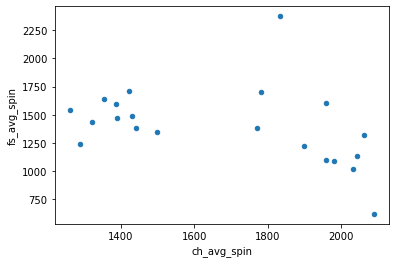

In [260]:
# changeup vs splitter (spin)
pitching_data.plot(kind='scatter', x = 'ch_avg_spin', y='fs_avg_spin');
pitching_data[['ch_avg_spin', 'fs_avg_spin']].corr()

This tells me they are not correlated. 

However, it is obvious spin behaves much differently for these pitches.  

From my knowledge of the game, spin may not play a big role in the success of these pitches when executed. We see this as changeup and splitter spins on average are much lower than the other pitches (see box plot). Therefore, I propose ignoring the spin of changeups and splitters because spin is not what makes these pitches effective. Rather it is the deception of these pitches to look like a fastball to get a batter to swing early. 


__Assumption__: We will be ignoring changeup and splitter spin.

Hence, we have two spins: fastball spin and breaking ball spin. Let's see how well correlated these two are.

,avg_fastball_spin,avg_breaking_spin
avg_fastball_spin,1.000000,0.489571
avg_breaking_spin,0.489571,1.000000


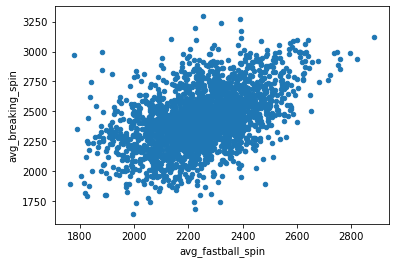

In [261]:
# fastball (ff, si, fc) spin vs breaking (sl, cu) spin
pitching_data.plot(kind='scatter', x = 'avg_fastball_spin', y='avg_breaking_spin');
pitching_data[['avg_fastball_spin', 'avg_breaking_spin']].corr()

We see that fastball spin versus breaking spin is moderately correlated. In short, those who tend to have a high spin on their fastball tend to also have a high spin on their breaking balls. If I were to use both of these as a feature, then it may hurt interpretability because it may seemingly weaken the effect spin might have on a pitcher's success (due to the fact these two features seem to be not entirely independent). 

Therefore, it may serve us to just combine the fastball and breaking ball spin into one avg_spin column. However, this would still be ignoring changeup and splitter for the reason that spin is significantly lower for these pitches while spin is not meant to augment these pitches.

__Assumption__: Average spin incorporates all pitches except changeups and splitters.

In [262]:
# create new column called average spin that is the mean of all the fastball and breaking ball spins
pitching_data['avg_spin'] =round(pitching_data[['avg_fastball_spin', 'avg_breaking_spin']].mean(axis=1), 1)

Compare Average Spin to WAR

,avg_spin,WAR
avg_spin,1.000000,0.097467
WAR,0.097467,1.000000


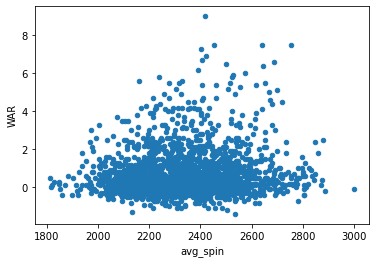

In [263]:
#graph the fastest speed of pitchers compared to their WAR to see if we could use it as a feature

pitching_data.plot(kind='scatter', x='avg_spin', y='WAR')
pitching_data[['avg_spin', 'WAR']].corr()

Spin seems to be less correlated to WAR than speed. The correlation is very weak. This does not make a good case to use spin as a feature. However, spin was a very controversial topic during the 2021 season because of the use of artificial substances to boost the rotations on the ball (see https://www.nysportsday.com/2021/06/09/the-spin-rate-mlb-sticky-issue/). There seemed to be a very real concern about increasing spin to get better results, and for that reason I am motivated to include spin as a feature.

### Compare Speed to Spin

,avg_fastest_speed,avg_spin
avg_fastest_speed,1.000000,0.237277
avg_spin,0.237277,1.000000


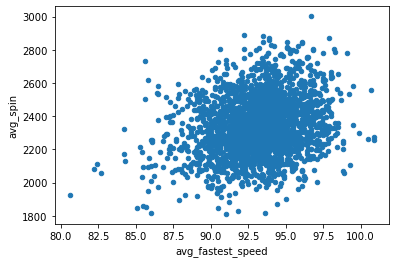

In [264]:
# pitcher's average fastest pitch vs pitcher's average spin
pitching_data.plot(kind='scatter', x = 'avg_fastest_speed', y='avg_spin');
pitching_data[['avg_fastest_speed', 'avg_spin']].corr()

Speed and spin seem to be weakly correlated, but correlated nonetheless which may hinder the features ability to be independent from each other. Though, it is weak, which means it may still be worth using both of these features when fitting a model. For the reason that it is a fairly weak correlation, I will be using avg_fastest_speed and avg_spin as features to measure against the response variable WAR (successful).

## Other Information we can use About Pitcher's Pitch Arsenal

Other than the speed and spin of the ball of each type of pitch thrown by a pitcher, what other data can we extract? 

### How often is a pitch thrown

The columns where this information can be found is in columns n_ff, n_si, n_fc, n_sl, n_ch, n_cu, and n_fs. Essentially, if n_ff = 0.5, then the pitcher has thrown a fastball 50% of the time. 

In the notebook "Get data for unit-4 project", I did some feature engineering to figure out pitcher's favorite pitch and their second favorite pitch. That way I could dummify those columns and use them in an analysis. The reason I did this was in the case I might want to predict scouting data. Scouting data is not going to have the percentage of pitches thrown, but instead a ranking of those pitcher's favorite pitch. Because each pitcher has at least two pitches, I could use that fact to compare this dataset with scouting data (if I get to that point later in the project).

At this point in the notebook, I don't know if I will use the percentages or the favorite pitches, but I will be using one or the other

In [265]:
pitching_data[['last_name', ' first_name', 'mlbam_id', 'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'Fav_pitch',
       'Fav_pitch_2']].head()

,last_name,first_name,mlbam_id,n_ff,n_si,n_fc,n_sl,n_ch,n_cu,n_fs,Fav_pitch,Fav_pitch_2
0,Clase,Emmanuel,661403,0.9,0.0,69.3,29.7,0.0,0.0,0.0,fc,sl
1,Clase,Emmanuel,661403,5.5,0.0,73.3,21.2,0.0,0.0,0.0,fc,sl
2,Hicks,Jordan,663855,1.4,68.1,26.1,1.0,3.4,0.0,0.0,si,fc
3,Hicks,Jordan,663855,0.2,60.3,0.0,34.7,4.8,0.0,0.0,si,sl
4,Hicks,Jordan,663855,1.9,76.1,0.0,22.0,0.0,0.0,0.0,si,sl


## Distribution of pitches

Located in the data above is how often a pitcher throws a certain pitch type. Often times, if a pitcher throws too much of a certain pitch, the batter might catch on and sit on that pitch to hit. Theoretically, a strategic distribution of pitches are thrown in order to keep the batter on their toes.

Below are the average percentages each type of pitch is thrown across the dataset (does not count if a pitcher does not throw that pitch at all).

In [266]:
pitching_data[['n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs']].mean()

n_ff    36.331932
n_si    16.690714
n_fc     6.086465
n_sl    19.631099
n_ch    10.390802
n_cu    10.001927
n_fs     0.868112
dtype: float64

Based on the above, it seems that pitchers favor their fastball (ff) the most compared to other pitch types. However, the above does not show a full picture as these columns contain many null values.

Regardless, I don't expect these values to contribute much in predicting WAR. Looking below is a graph of the percentage of fastballs thrown versus WAR. There is not enough of a correlation to make a conclusion, however, I do notice that the best pitchers (WAR > 5) do not throw a fastball more than 60% of the time.

,n_ff,WAR
n_ff,1.000000,-0.016961
WAR,-0.016961,1.000000


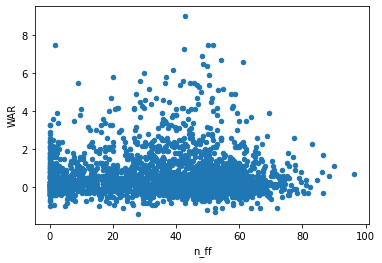

In [267]:
pitching_data.plot(kind='scatter', x='n_ff', y='WAR')
pitching_data[['n_ff', 'WAR']].corr()

### How many pitches does a pitcher throw

A pitcher who has a lot of pitches is much harder to predict. As a batter, if I know my opponent only throws fastballs, then I can sit on one pitch. If it is a fastball and a slider, then it is one or the other. If my opponent has 5 pitches, then it truly becomes a guessing game.

,Num_pitches,WAR
Num_pitches,1.000000,0.186561
WAR,0.186561,1.000000


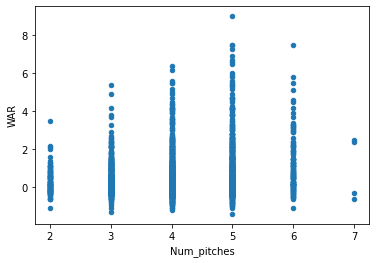

In [268]:
pitching_data.plot(kind='scatter', x='Num_pitches', y='WAR')
pitching_data[['Num_pitches', 'WAR']].corr()

The nature of this graph having discrete values versus continuous makes it hard to make a conclusion about whether or not the number of pitches is correlated to WAR. It looks Gaussian, but it's hard to tell since the values are discrete. Because this was constructed from how often a pitch is thrown, there may be multicolinearity involved, so this feature will be used as a replacement of the 'n_(pitch)' features.

### Favorite Pitches

Alternatively, we can see which pitches are most favored by pitchers by looking at a pitcher's first and second most thrown pitch. This is captured in the Fav_pitch and Fav_pitch_2 columns.

We can graph a bar chart of a pitcher's most thrown pitch type.

Text(0.5, 1.0, "Distribution of pitcher's most thrown pitch type")

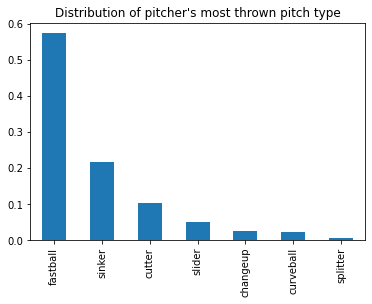

In [269]:
fig, ax = plt.subplots()

pitch_types = ['fastball', 'sinker', 'cutter', 'slider', 'changeup', 'curveball', 'splitter']

pitching_data.Fav_pitch.value_counts(normalize=True).plot(kind="bar", rot=90, ax=ax)

ax.set_xticklabels(pitch_types)
plt.title("Distribution of pitcher's most thrown pitch type")

The fastball seems to be a clear favorite. In fact, pitches that are grouped together in the category of "fastball" (i.e. fastballs, sinkers, and cutters) are overwhelming the most thrown pitch in a pitcher's arsenal. It shows that throwing a pitch hard is universally accepted as the standard way to pitch (there are variations like knuckleball pitchers).

Let's also look at pitcher's second favorite pitch.

Text(0.5, 1.0, "Distribution of pitcher's second most thrown pitch type")

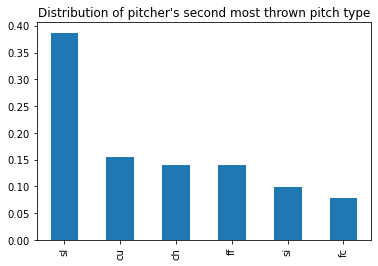

In [270]:
fig_2, ax_2 = plt.subplots()

pitch_types_2 = ['slider', 'curveball', 'changeup', 'fastball', 'sinker', 'cutter', 'splitter']

pitching_data.Fav_pitch_2.value_counts(normalize=True).plot(kind="bar", rot=90, ax=ax_2)

ax.set_xticklabels(pitch_types_2)
plt.title("Distribution of pitcher's second most thrown pitch type")

Interestingly, a pitcher's second go-to pitch is most likely a slider. This is followed by curveballs and changeups. It shows that a pitcher usually seclects one type of fastball, and one type of offspeed pitch as the two main pitches in their arsenal.

We won't be using these at first as this was built from 'n_(pitch)', and if both are used there would be multicolinearity issues. However, if we download prospect data, it may not have 'n_(pitch)' data explicitly, but rather a list of the pitcher's best pitches. Therefore, this may be useful in comparing prospects to major leaguers. 

If we end up wanting to use Fav_pitch and Fav_pitch_2, we should dummify it. This is so we can translate categorical data into a readable format for machine learning

In [271]:
#dummify Fav_pitch and Fav_pitch2

pitching_data = pitching_data.join(pd.get_dummies(pitching_data['Fav_pitch'], prefix='Fav_pitch'))
pitching_data = pitching_data.join(pd.get_dummies(pitching_data['Fav_pitch_2'], prefix='Fav_pitch_2'))

#need to drop a single dummy column for multicollinearity purposes
pitching_data.drop(columns=['Fav_pitch_fs'], inplace=True)
pitching_data.drop(columns=['Fav_pitch_2_fc'], inplace=True)

## Measuring a Pitcher's Accuracy

While a pitcher's arsenal can suggest a lot on how difficult a pitcher is to hit, it doesn't mean anything if a pitcher cannot throw strikes. Furthermore, a pitcher needs to be precise with their pitches. Maybe the pitcher can throw strikes, but if they throw it right down the middle instead of the corners, they might be giving up a lot of easy hits or homeruns. Accuracy can be the difference for a sub-par pitcher to come ahead of a pitcher with lighting stuff.

### BB/9 (Walks per 9 innings pitched)

The proposed metric to measure a pitcher's ability to be "accurate" is BB/9, which stands for walks (BBs) given up per 9 innings pitched. Walks occur when a pitcher throws 4 balls in an at-bat. Balls occur when a pitch is thrown out of the strikezone without the batter swinging at the piitch. A pitcher never wants to give up walks because, unlike the batters ability to get a hit, giving up a walk is something that the pitcher can control. Therefore, a pitcher who gives up few walks often has great control of their pitches.

__NOTE__: BB/9 is not a perfect metric for accuracy. In fact, it barely scratches the surface. Sometimes throwing the ball out fo the strikezone is the most strategic thing to do. It is significantly more difficult to hit a pitch outside the strikezone, so good pitchers try to trick batters to swing at pitches outside. If a pitcher gives up a lot of walks, it might not mean they are not accurate. In fact, they might be throwing it exactly where they want, but they aren't fooling the batter. In that sense, BB/9 could be considered an indirect measure of success as good pitchers with nasty stuff have an easier time getting the count the way they want versus an accuracte pitcher who has sub-par pitches.

The reason why BB/9 is the best measure of accuracy is because, while it can't prove the pitcher can throw a pitch in a location whenever they want, it still shows which pitchers struggle to hit the strikezone when the count is at 3 balls. It makes me wonder if the mlb can track the movement of a catcher's glove to show a pitch's average deviation from the intended target.



,BB/9,WAR
BB/9,1.000000,-0.391982
WAR,-0.391982,1.000000


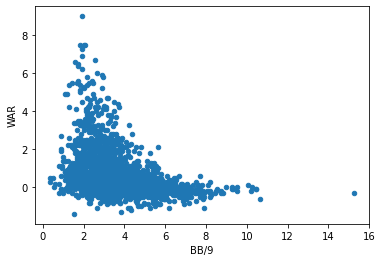

In [272]:
pitching_data.plot(kind='scatter', x='BB/9', y='WAR')
pitching_data[['BB/9', 'WAR']].corr()

There definitely seems to be some relationship between WAR and BB/9

### First pitch strike percentage

Another measure of accuracy that could be used is first pitch strike percentage. This represents the number of times a pitcher can throw a strike in the first pitch of an at bat. Throwing a first pitch strike or "getting ahead in the count" is a significant statistical advantage for the pitcher versus the count starting with 1 ball and no strikes. The options of what a pitcher can throw next after a first pitch strike is much greater than the alternative since they can experiment with pitches outside of the strikezone (to get the batter to chase). If the count is 1-0 (1 ball, no strikes), the pitcher has to try much harder to get that strike back.

First pitch strike means the batter has less of a chance to get on base. To throw a first pitch strike, a pitcher needs to be accurate.

__Note__: If we're talking about pure accuracy, first pitch strike is not ideal. For one, a pitcher doesn't want to throw a first pitch strike every time as that makes the pitcher predictable. Second, a pitcher's ability to get a first pitch strike depends also on the non-accuracy elements. If a sub-par pitch (slow, doesn't decieve a ton) is thrown in the strikezone for the first pitch, it may be more likely to be hit. On the other hand, a nasty pitch (decieves a ton) may be easier to sneak into the strikezone.

,F-Strike%,WAR
F-Strike%,1.000000,0.272715
WAR,0.272715,1.000000


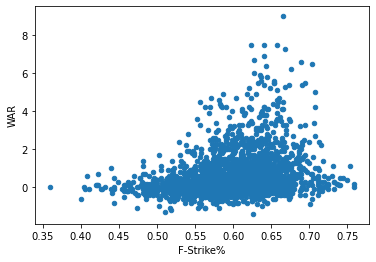

In [273]:
pitching_data.plot(kind='scatter', x='F-Strike%', y='WAR')
pitching_data[['F-Strike%', 'WAR']].corr()

In short, I could not find an ideal metric for a pitcher's ability to be accurate. A lot of it depends on what the other batter does, which is not something I can rely on for prospects who haven't faced mlb hitters yet. However, I will use these features because the accuracy of a pitcher is most definitely a part of the story to why a pitcher will be successful. 

Let's look at first pitch strike versus walks per 9 innings pitched and see how correlated they are.

,BB/9,F-Strike%
BB/9,1.000000,-0.497994
F-Strike%,-0.497994,1.000000


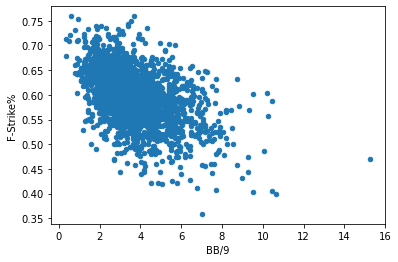

In [274]:
pitching_data.plot(kind='scatter', x='BB/9', y='F-Strike%')
pitching_data[['BB/9', 'F-Strike%']].corr()

They seem to have a moderate correlation against each other. This may hinder my the efficacy of using both of them in the same machine learning model. This might be a "1 or the other" type of decision.

## Throwing Hand

A pitcher's throwing hand is an important consideration for managers when choosing which pitcher to use against certain batters. Right handed pitchers throw the ball from the right, which means it has to travel leftwards to get to the center. Likewise, left handed pitchers throw from the left shoulder where the ball would need to travel right to get to the center. The angle at which the ball reaches the plate is different between a lefty and a righty. Is there an advantage as a pitcher to be either one?

Historically, it depends on the batter. Batters who hit opposite handed of the pitcher (e.g. batters lefty while the pitcher is righty) have a sight advantage because they can see the ball come out of the pitchers hand a tiny bit before. 

However, this project is trying to remove the batter from the equation, since prospects aren't going up against major league hitters yet. Regardless, whether a prospect is a lefty or a righty is an attractive question and could be a difference maker in evaluating a pitcher's value.

In [275]:
pitching_data.throws.value_counts()

R    1663
L     619
S       1
Name: throws, dtype: int64

There are right throwing pitchers and left throwing pitchers, but what is S? S means that there is a pitcher who throws both righty and lefty! 

In [276]:
pitching_data[pitching_data.throws=='S']

,Unnamed: 0,last_name,first_name,mlbam_id,ff_avg_speed,si_avg_speed,fc_avg_speed,sl_avg_speed,ch_avg_speed,cu_avg_speed,...,Fav_pitch_cu,Fav_pitch_fc,Fav_pitch_ff,Fav_pitch_si,Fav_pitch_sl,Fav_pitch_2_ch,Fav_pitch_2_cu,Fav_pitch_2_ff,Fav_pitch_2_si,Fav_pitch_2_sl
2275,2275,Venditte,Pat,519381,NaN,85.6,NaN,73.3,80.7,NaN,...,0,0,0,0,1,0,0,0,1,0


His name is Pat Venditte. I give him an honorable mention because now I'm going to remove him from the data. Since there is only one ambidextrous pitcher- in the data, he is an outlier. And, if I can get rid of outliers, great.

In [277]:
index = pitching_data[pitching_data.throws=='S'].index
pitching_data.drop(index, inplace=True)

Going back to the value counts

In [278]:
pitching_data.throws.value_counts(normalize=True)

R    0.728747
L    0.271253
Name: throws, dtype: float64

There are considerably more righty pitchers than lefty pitchers. This is most likely because left handed people are less common than right handed people.

Let's look at the average WAR for righty and lefties

In [279]:
print('mean: ',pitching_data['WAR'][pitching_data.throws == 'R'].mean())
print('median: ', pitching_data['WAR'][pitching_data.throws == 'R'].median())

mean:  0.6154539987973542
median:  0.3


In [280]:
print('mean: ', pitching_data['WAR'][pitching_data.throws == 'L'].mean())
print('median: ', pitching_data['WAR'][pitching_data.throws == 'L'].median())

mean:  0.6689822294022627
median:  0.3


Suprisingly righty and lefty pitchers have the same exact median! The mean WAR for lefties is slightly greater than righties, but not by much.

Text(0.5, 1.0, 'WAR of Lefty versus Righty pitchers')

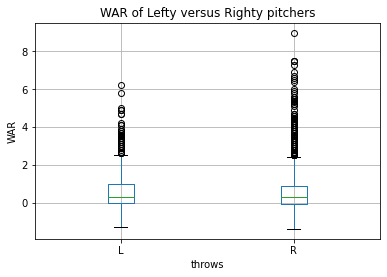

In [281]:
fig, ax = plt.subplots()
pitching_data.boxplot(column='WAR',by='throws', ax=ax)
plt.suptitle('') 
plt.ylabel('WAR')
plt.title('WAR of Lefty versus Righty pitchers')

This is very shocking to me because in my experience playing baseball as a youth, lefties were always prized for their uniqueness. What this is saying is that the average lefty mlb pitcher has nearly the same WAR as the average righty mlb pitcher.

Let's dummify Right versus Left since this is categorical data.

In [282]:
pitching_data['throws'].replace({'R': 0, 'L': 1}, inplace=True)

## Look at Height and Weight

The height of a pitcher may influence how a pitch is recieved by the batter. For one, the ball is often released at a different angle than a shorter pitcher, as the pitcher has to throw the ball downwards to reach the strikezone. Furthermore, a taller pitcher may be able to get the point at which they release the ball much closer to the batter's plate than a shorter pitcher. A shorter distance to the plate means the ball will get their faster, meaning the ball is percieved faster than it's raw miles per hour.

,height,WAR
height,1.000000,0.090537
WAR,0.090537,1.000000


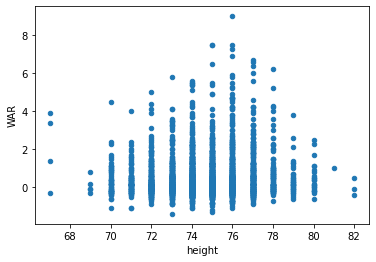

In [283]:
#height versus WAR
pitching_data.plot(kind='scatter', x='height', y='WAR')
pitching_data[['height', 'WAR']].corr()

Interestingly, the hieght of a pitcher when compared to a pitcher's WAR takes a somewhat gaussian shape (acknowledging the fact that height is measured discretely). Might consider using height, but it isn't much of a priority.

,weight,WAR
weight,1.000000,0.007011
WAR,0.007011,1.000000


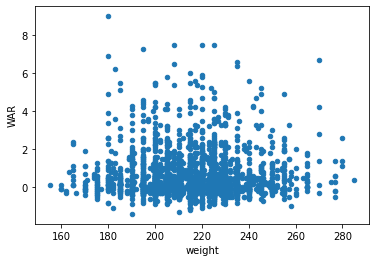

In [284]:
pitching_data.plot(kind='scatter', x='weight', y='WAR')
pitching_data[['weight', 'WAR']].corr()

As for weight, there doesn't seem to be any correlation. Therefore, we won't consider weight as a feature.

# 4. Machine Learning

In [285]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler


## Define Variables

Prior to beginning the machine learning process, I need to define what my feature columns and response variable. The feature columns are made up of BB / 9 (for accuracy of pitcher), average fastest speed and average spin (the ability of a pitcher to sling the ball), and the number of pitches and the percentage at which these pitchers are thrown (how diverse is the pitcher's arsenal). I may also want to throw in other features that I recorded to see how the model holds up.

As for the response variable, we uses successful because for logistic regression, we are solivng a classification problem. Is the pitcher successful or not?

In [286]:
pitching_data.columns

Index(['Unnamed: 0', 'last_name', ' first_name', 'mlbam_id', 'ff_avg_speed',
       'si_avg_speed', 'fc_avg_speed', 'sl_avg_speed', 'ch_avg_speed',
       'cu_avg_speed', 'fs_avg_speed', 'ff_avg_spin', 'si_avg_spin',
       'fc_avg_spin', 'sl_avg_spin', 'ch_avg_spin', 'cu_avg_spin',
       'fs_avg_spin', 'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs',
       'Season', 'F-Strike%', 'BB/9', 'Age', 'WAR', 'K/9', 'ERA', 'Fav_pitch',
       'Fav_pitch_2', 'Num_pitches', 'throws', 'weight', 'height',
       'successful', 'avg_fastest_speed', 'avg_fastball_spin',
       'avg_breaking_spin', 'avg_spin', 'Fav_pitch_ch', 'Fav_pitch_cu',
       'Fav_pitch_fc', 'Fav_pitch_ff', 'Fav_pitch_si', 'Fav_pitch_sl',
       'Fav_pitch_2_ch', 'Fav_pitch_2_cu', 'Fav_pitch_2_ff', 'Fav_pitch_2_si',
       'Fav_pitch_2_sl'],
      dtype='object')

In [342]:
#define our feature columns

feature_cols = ['BB/9','avg_spin', 'avg_fastest_speed', 'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'throws']

X = pitching_data[feature_cols]
y = pitching_data['successful']

### Null Hypothesis (Classification)

Before doing any machine learning, we need to define our null hypothesis. What are we trying to beat? 

The Null hypothesis states that there is no relationship between the variables used in predicting our outcome. On th eohter hand, the alternative hypothesis states that there is a relationship. Henceforth, we want to reject the Null Hypothesis, otherwise our model does not work.

In defining the baseline for classification, let us look at the distribution of successful pitchers.

In [288]:
pitching_data['successful'].value_counts(normalize=True)

1    0.656004
0    0.343996
Name: successful, dtype: float64

We see that about 2/3 of pitchers in the Major Leagues from 2018-2021 are considered successful (with a positive WAR). If we had no information to go off of besides this, then we would predict that all pitchers are successful and have an accuracy of (most likely) ~66%. 

Therefore, we want our model to be able to successfully predict a pitcher's success over 66%.

Let's confirm this with a Dummy Classifer based on the most frequent class.

In [289]:
from sklearn.dummy import DummyClassifier

In [290]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X,y, random_state=21) #test train split
dummy_model = DummyClassifier(strategy='most_frequent') #instantiate
dummy_model.fit(X_train_dummy, y_train_dummy) #fit 
dummy_preds = dummy_model.predict(X_test_dummy) #predict
print('Accuracy ', metrics.accuracy_score(y_test_dummy, dummy_preds)) #score

Accuracy  0.6164623467600701


Use k-fold validation to diversify the training set. And then record scores.

In [291]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)
print('accuracy:', np.mean(cross_val_score(dummy_model, X, y, cv=kf, scoring='accuracy')))
print('precision:', np.mean(cross_val_score(dummy_model, X, y, cv=kf, scoring='precision')))
print('recall:', np.mean(cross_val_score(dummy_model, X, y, cv=kf, scoring='recall')))


accuracy: 0.6560136665514991
precision: 0.6560136665514991
recall: 1.0


The baseline to beat is the above the percentage of the most frequent class (successful).

## Logistic Regression

Import relevant libraries

Do an intial train test split to see if logistic regression can defeat the baseline.

In [292]:
#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=21)


#Build our model

logreg = LogisticRegression(max_iter=1500, random_state=89)

logreg.fit(X_train,y_train)

logistic_pred_class = logreg.predict(X_test)

#Measure accuracy
print('Accuracy ', metrics.accuracy_score(y_test, logistic_pred_class))

Accuracy  0.702276707530648


Let's check the baseline, looking at the number of successful versus non-successful pitchers in the training dataset.

In [293]:
y_train.value_counts(normalize=True)

1    0.669199
0    0.330801
Name: successful, dtype: float64

Given that the baseline is 66.8%, this just beats out the baseline. While it only beats the baseline by a few percentage points, it does show that this model is informed in making predictions and is better than having no knowledge at all.

Let's do cross validation to make sure the accuracy isn't a fluke. Cross validation will be using 5 folds, which means that it will slit the data into a number of different folds and train using a set amount of train-test-splits. By averagin these out, we can get a better sense of how well the model will do. 

In [294]:
#try 5 splits (also tried up to 10 and it provided similar results)
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)

print('accuracy:', np.mean(cross_val_score(logreg, X, y, cv=kf, scoring='accuracy')))
print('precision:', np.mean(cross_val_score(logreg, X, y, cv=kf, scoring='precision')))
print('recall:', np.mean(cross_val_score(logreg, X, y, cv=kf, scoring='recall')))

accuracy: 0.747144804023187
precision: 0.7618307192507283
recall: 0.8945967764045377


This still beats out the baseline by just under 10 percentage points (74% vs 66%). It validates the model can beat the baseline.

To get a better understanding of how the model is predicting, let's look at a confusion matrix.

#### Confusion Matrix: 
Top left is true negative, top right is false positive, bottom left is false negative, and bottom right is true positives.

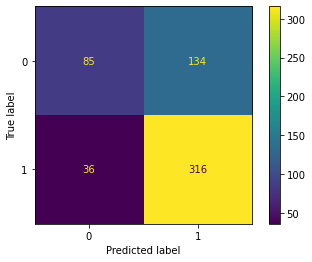

In [295]:
metrics.plot_confusion_matrix(logreg, X_test, y_test)

We see that the model is skewed towards making true positive decisions. This is because the distribution of successful pitchers (as defined) is much greater than unsuccessful pitchers. Therefore, it makes sense that the logistic regression model would have many true positives, while have few false negatives. While it is not great to see such a skew, it is good to see that the model does make some predictions that a pitcher is unsuccessful and beats the baseline.

We can also look at the area under a roc_auc curve to get a better understanding of how well the model performs.

In [296]:
from sklearn.metrics import roc_auc_score
print('roc auc score logistic regression', roc_auc_score(y_true=y_test, y_score=logistic_pred_class))
print('roc_auc_score no skill', roc_auc_score(y_true=y_test_dummy, y_score=dummy_preds))

roc auc score logistic regression 0.6429275633042757
roc_auc_score no skill 0.5


Even though a roc auc score of 0.64 is not great, it shows that the model does show skill. 

### Logistic Regression Conclusion

This machine learning model when applied to this problem does reject null hypothesis! However, the fact that it only climbs a few percentage points in accuracy is not particularly satisfying. Therefore, I am inclined to try additional models to see if we can get a better classification model.

# Gaussian Naive Bayes

Let's try another model: Gaussian Naive Bayes. This is a probabalistic algorithm based on Bayes theorem. It is Naive because it assumes the featuers are independent (which isn't 100% true, especially with BB/9 vs F-Strike%)

In [297]:
from sklearn.naive_bayes import GaussianNB
#y = pitching_data['successful']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=45)

#Build our model

gnb = GaussianNB()

gnb.fit(X_train,y_train)

gnb_pred_class = gnb.predict(X_test)

#Measure accuracy
print('Accuracy ', metrics.accuracy_score(y_test, gnb_pred_class))

Accuracy  0.7460595446584939


In [298]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)

print('accuracy:', np.mean(cross_val_score(gnb, X, y, cv=kf, scoring='accuracy')))
print('precision:', np.mean(cross_val_score(gnb, X, y, cv=kf, scoring='precision')))
print('recall:', np.mean(cross_val_score(gnb, X, y, cv=kf, scoring='recall')))

accuracy: 0.7348717801067219
precision: 0.7540625449183989
recall: 0.8877278357675726


This beats the baseline, but performs worse than logestic regression.

## Support Vector Machine Classifier

In [299]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=45)

svc = SVC()

svc.fit(X_train,y_train)

svc_pred_class = svc.predict(X_test)

#Measure accuracy
print('Accuracy ', metrics.accuracy_score(y_test, svc_pred_class))

Accuracy  0.6514886164623468


In [343]:
print('accuracy:', np.mean(cross_val_score(svc, X, y, cv=kf, scoring='accuracy')))
print('precision:', np.mean(cross_val_score(svc, X, y, cv=kf, scoring='precision')))
print('recall:', np.mean(cross_val_score(svc, X, y, cv=kf, scoring='recall')))

accuracy: 0.6560136665514991
precision: 0.6560136665514991
recall: 1.0


Does not beat the baseline; therefore, we do not want to use this model.

# Decision Tree Classifier

In [300]:
from sklearn.tree import DecisionTreeClassifier

Let's check what depth gives us the best accuracy.

In [301]:
depths = range(1,16)

accuracy_scores = []

for depth in depths:
    DTC = DecisionTreeClassifier(max_depth=depth, random_state=3)
    accuracy_score = cross_val_score(DTC, X, y, cv=10, scoring='accuracy')
    accuracy_scores = np.append(accuracy_scores, np.mean(accuracy_score))

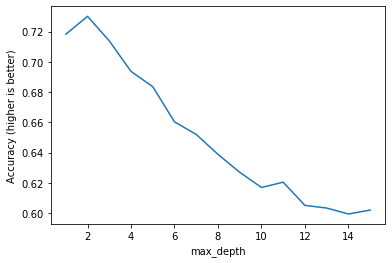

In [302]:
plt.plot(depths, accuracy_scores);
plt.xlabel('max_depth');
plt.ylabel('Accuracy (higher is better)');

In [303]:
print(accuracy_scores)

[0.71824868 0.73006205 0.7138359  0.69366812 0.68359764 0.66035394
 0.65203018 0.63888761 0.62704934 0.61698269 0.62048954 0.60514633
 0.60339769 0.59946181 0.60206466]


The most accurate depth is a max_depth of 2. This is very telling that one of the features is dominating the classification process.

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=45)

#Build our model

DTC = DecisionTreeClassifier(max_depth=2, random_state = 45)

DTC.fit(X_train,y_train)

DTC_pred_class = DTC.predict(X_test)

#Measure accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, DTC_pred_class))
print('precision: ', metrics.precision_score(y_test, DTC_pred_class))
print('recall: ', metrics.recall_score(y_test, DTC_pred_class))

Accuracy:  0.7338003502626971
precision:  0.7594339622641509
recall:  0.8655913978494624


In [305]:
# Compute the feature importances (the Gini index at each node).

df=pd.DataFrame({'feature':feature_cols, 'importance':DTC.feature_importances_})
df

,feature,importance
0,BB/9,1.0
1,avg_spin,0.0
2,avg_fastest_speed,0.0
3,n_ff,0.0
4,n_si,0.0
5,n_fc,0.0
6,n_sl,0.0
7,n_ch,0.0
8,n_cu,0.0
9,n_fs,0.0


Haa. Yeahhhh. It seems that BB/9 is by FAR the most important feature in determining a pitcher's WAR (out of the other features listed above). There could be a number of reasons why this is true. It doesn't help that pitch percentage is dummified, so it's hard to see it's feature importance in this context.

For this reason, it may be worth trying a Random Forest instead of a single decision tree. This is because we want the tree to consider other features than just BB/9. Random Forests builds multiple trees, but when building each tree, a random sample of features is chosen out of the initial pool each time a split is made. In that split, only those features are allowed to be used. This will diversify the feature selection when making a classification.

## Random Forest Classifier

First, I need to find the best number of estimators. This is done by using a loop in which we run a new random forest model with a new number of estimators.

In [306]:
from sklearn.ensemble import RandomForestClassifier

In [355]:
#THIS CELL IS SLOW. BE AWARE

# List of values to try for n_estimators:
estimator_range = range(10, 500, 10)

# List to store the average accuracy for each value of n_estimators:
accuracies = []

# Use five-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    rfclass = RandomForestClassifier(n_estimators=estimator, max_features=4, random_state=1)
    accuracy = cross_val_score(rfclass, X, y, cv=kf, scoring='accuracy')
    accuracies.append(np.mean(accuracy))

Plot the average accuracies versus number of estimators

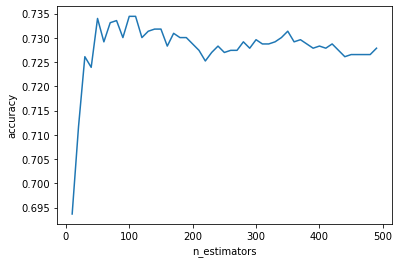

In [356]:
plt.plot(estimator_range, accuracies);

plt.xlabel('n_estimators');
plt.ylabel('accuracy');

Choose the best one

In [357]:
sorted(list(zip(accuracies, estimator_range)), reverse=True)[0]

(0.7344312641560137, 110)

This accuracy is still much lower than linear regression. It barely beats out the baseline, but this is the type of result that would be hard to reject the null hypothesis (that the features cannot infer the response variable).

Regardless, it is an opportunity to look at the features now that BB/9 is not as heavily weighted.

In [358]:
#instantiate a Random Forest Classifier using 100 n_estimators and a max number of features on each split of 5
rfclass = RandomForestClassifier(n_estimators=110,
                              max_features=4,
                              oob_score=True,
                              random_state=1)
#fit the ml model
rfclass.fit(X, y)

RandomForestClassifier(max_features=4, n_estimators=110, oob_score=True,
                       random_state=1)

Let's see the random forest intrepretation of ranking features on importance.

In [359]:
pd.DataFrame({'feature':feature_cols,
              'importance':rfclass.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
0,BB/9,0.280370
1,avg_spin,0.115893
2,avg_fastest_speed,0.115212
3,n_ff,0.106184
7,n_ch,0.089052
6,n_sl,0.086542
4,n_si,0.074827
8,n_cu,0.072269
5,n_fc,0.034228
10,throws,0.015659


Now at least we have a sense of what values contribute the most in determing a pitcher's success. The two leading features are walks per 9 innings pitched and first strike percentage. This is followed by the speed of a pitcher's fastest pitch and their average spin. All the others kind of blend in together, partially becuase they have been dummified.

It shows that a pitcher's ability to throw strikes (versus balls) is the most important when determining if that pitcher will be successful.

Another takeaway from the above is is how irrelevant the number of pitches thrown by a pitcher is to their success. It's shocking because I would have assumed that having more pitches means that you are more unpredictable, but clearly the number of pitches you throw does not correlate with success.

In [360]:
#calculate the accuracy of the random forest model one more time using a 5 fold cross validation
print('accuracy:', np.mean(cross_val_score(rfclass, X, y, cv=kf, scoring='accuracy')))
print('precision:', np.mean(cross_val_score(rfclass, X, y, cv=kf, scoring='precision')))
print('recall:', np.mean(cross_val_score(rfclass, X, y, cv=kf, scoring='recall')))


accuracy: 0.7344312641560137
precision: 0.7591634918114093
recall: 0.8734947462221699


#### Classification Conclusion:

It seems that the best model at predicting a pitcher's success (out of the ones I've tested) is linear regression. While linear regression beats the baseline, it only beats it by less than 10 percentage points, which is decent but not amazing. This is to be expected as pitching is complex in that it most likely cannot be summed up by a few metrics. 

However, separating a pitcher by successful versus not-successful may actually be detrimental. A pitcher who has a WAR of 6 is significantly better than a pitcher who has a WAR of 0.1. The best way to do this is regression rather than classification (predicting WAR instead of successful). Regardless, it was a good exercise of classification, which is why I started off with this rather than jump straight to regression.

In [322]:
pitching_data.columns

Index(['Unnamed: 0', 'last_name', ' first_name', 'mlbam_id', 'ff_avg_speed',
       'si_avg_speed', 'fc_avg_speed', 'sl_avg_speed', 'ch_avg_speed',
       'cu_avg_speed', 'fs_avg_speed', 'ff_avg_spin', 'si_avg_spin',
       'fc_avg_spin', 'sl_avg_spin', 'ch_avg_spin', 'cu_avg_spin',
       'fs_avg_spin', 'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs',
       'Season', 'F-Strike%', 'BB/9', 'Age', 'WAR', 'K/9', 'ERA', 'Fav_pitch',
       'Fav_pitch_2', 'Num_pitches', 'throws', 'weight', 'height',
       'successful', 'avg_fastest_speed', 'avg_fastball_spin',
       'avg_breaking_spin', 'avg_spin', 'Fav_pitch_ch', 'Fav_pitch_cu',
       'Fav_pitch_fc', 'Fav_pitch_ff', 'Fav_pitch_si', 'Fav_pitch_sl',
       'Fav_pitch_2_ch', 'Fav_pitch_2_cu', 'Fav_pitch_2_ff', 'Fav_pitch_2_si',
       'Fav_pitch_2_sl'],
      dtype='object')

## Define Variables (Regression)

Same feature columns as the classification section; however, the response variable is now WAR (continuous versus discrete).

In [362]:
feature_cols = ['BB/9','F-Strike%','avg_spin', 'avg_fastest_speed',  'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'throws']
X = pitching_data[feature_cols]
y = pitching_data['WAR']

## Null Hypothesis (Regression)

I need to set some sort of baseline to beat when looking at regression.

In [324]:
from sklearn.dummy import DummyRegressor #use Dummy Regressor to set baseline

In [325]:
#let's experiment with pipeline as an exercise
#I wanted to see if StandardScaler would change anything (didn't really)
from sklearn.pipeline import Pipeline
pipe_dummy = Pipeline([("StSclr", StandardScaler()),
                   ("dummy", DummyRegressor(strategy='mean'))])

Find r squared and Root Mean Squared Error to see what we should try to beat.

In [326]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)

dummy_model_regressor = DummyRegressor(strategy='mean') #instantiate

print('R-squared:', np.mean(cross_val_score(pipe_dummy, X, y, cv=kf)))
print('RMSE:', np.sqrt(np.mean(-cross_val_score(pipe_dummy, X, y, cv=kf, scoring='neg_mean_squared_error'))))


R-squared: -0.0016354552892698048
RMSE: 1.1616215178640923


The R-squared is telling us that just using the mean does not fit the data at all (negative). It was even worse when I tried median. Therefore, we should try to strive for a positive R-squared and a RMSE below ~1.15

## Linear Regression

In [327]:
from sklearn.linear_model import LinearRegression


X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=45)

lr = LinearRegression() #instantiate

lr.fit(X_train,y_train) #fit

lr_pred_class = lr.predict(X_test) #predict

#Measure error
print('RMSE ', np.sqrt(metrics.mean_squared_error(y_test, lr_pred_class)))

RMSE  1.055933836916692


cross-validation makes me feel better, but I did the above as practice

In [328]:
#try 5 splits (also tried up to 10 and it provided similar results)
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)
print('R-squared:', np.mean(cross_val_score(lr, X, y, cv=kf)))
print('RMSE:', np.sqrt(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error'))))



R-squared: 0.2236281995793176
RMSE: 1.0224040532759024


This is a weak R-squared (0.21), but it does beat the baseline. At the very least, the model weakly fits the data. What this tells us that the model can predict a pitcher's WAR value plus or minus 1. Considering that most pitchers have a WAR between 0 and 1, this is not very helpful. However, if we predict a pitcher to have a WAR a decent amount above 1 (say 1.5), then it may be a good bet that this pitcher will be successful. MLB scouts always look for the best MLB prospects, and they don't always pan out so this result may reflect that.

Let's look at other models to see if they may do better.

In [329]:
import statsmodels.api as sm
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

In [330]:
# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WAR   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     56.88
Date:                Sun, 19 Dec 2021   Prob (F-statistic):          2.74e-120
Time:                        15:14:21   Log-Likelihood:                -3279.2
No. Observations:                2282   AIC:                             6584.
Df Residuals:                    2269   BIC:                             6659.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -24.6804     36.557     -0.675      0.500     -96.370      47.009
BB/9                 -0.2936      0.017    -17.607      0.000      -0.326      -0.261
F-Strike%             2.4221      0.456      5.315      0.000       1.529       3.316
avg_spin              0.0006      0.000      4.797      0.000       0.000       0.001
avg_fastest_speed     0.1079      0.010     11.062      0.000       0.089       0.127
n_ff                  0.1293      0.366      0.353      0.724      -0.588       0.846
n_si                  0.1301      0.366      0.356      0.722      -0.587       0.847
n_fc                  0.1323      0.366      0.362      0.718      -0.585       0.849
n_sl                  0.1346      0.366      0.368      0.713      -0.582       0.852
n_ch                  0.1389      0.366      0.380      0.704      -0.578       0.856
n_cu                  0.1438      0.366      0.393      0.694      -0.573       0.861
n_fs                  0.1462      0.366      0.400      0.689      -0.571       0.863
throws                0.2697      0.051      5.302      0.000       0.170       0.370
==============================================================================
Omnibus:                      973.999   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5402.167
Skew:                           1.960   Prob(JB):                         0.00
Kurtosis:                       9.438   Cond. No.                     4.01e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [331]:
X=feature_cols = ['BB/9','F-Strike%','avg_spin', 'avg_fastest_speed',  'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'throws']
X = pitching_data[feature_cols]

## Decision Tree Regressor

In [332]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

Let's tune the decision tree first. Let's find the best max depth of the tree.

In [333]:
# List of values to try for max_depth:
max_depth_range = range(1, 30)

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

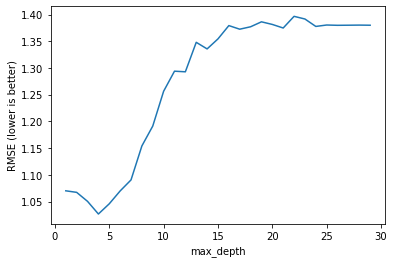

In [334]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [335]:
#use grid search to get the best parameters
n=range(1,15)
params={'max_depth': n}
gs = GridSearchCV(DecisionTreeRegressor(random_state = 1),
                  param_grid=params,
                  cv=4)
gs.fit(X, y)
gs.best_params_

{'max_depth': 4}

The best max depth is 4. Let's fit it to some test data and predict.

In [336]:
#y = pitching_data['successful']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=45)

#Build our model

DTR = DecisionTreeRegressor(max_depth=4, random_state=6)

print('Cross Validated R-squared:', np.mean(cross_val_score(DTR, X, y, cv=kf)))
print('Cross Validated RMSE:', np.sqrt(np.mean(-cross_val_score(DTR, X, y, cv=kf, scoring='neg_mean_squared_error'))))

Cross Validated R-squared: 0.19783721031613233
Cross Validated RMSE: 1.0382500082442134


In [337]:
DTR.fit(X,y)
pd.DataFrame({'feature':feature_cols,
              'importance':DTR.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
0,BB/9,0.624795
3,avg_fastest_speed,0.184663
9,n_cu,0.125074
1,F-Strike%,0.055266
7,n_sl,0.005611
2,avg_spin,0.004592
4,n_ff,0.000000
5,n_si,0.000000
6,n_fc,0.000000
8,n_ch,0.000000


Again, BB/9 dominates. What shocks me is the importance of the percentage of curveballs thrown. It's somehow greater than the average spin on the baseball, which astonishes me considering the emphasis on spin rate in baseball in recent years! 

However, I also realize that this is indicative of what the above model thinks is important and is not an objective assessment of the features.

In [338]:
print('Cross Validated R-squared:', np.mean(cross_val_score(DTR, X, y, cv=kf)))
print('Cross Validated RMSE:', np.sqrt(np.mean(-cross_val_score(DTR, X, y, cv=kf, scoring='neg_mean_squared_error'))))

Cross Validated R-squared: 0.19783721031613233
Cross Validated RMSE: 1.0382500082442134


Similar to the case in classification, it seems the decision tree just slightly underperforms the linear regression model.

Lastly, let's check the random forest regressor to get more exposure to alll the features.

## Random Forest Regressor

In [339]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor() #instantiate

Let's tune the Random Forest Regressor Model. Let's get the number of estimators down. Mind that the tuning is a slow process.

In [363]:
# CELL IS SLOW, BE CAREFUL BEFORE RUNNING
estimator_range = range(10, 500, 10)

RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=33)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Minimize Root Mean Squared Error.

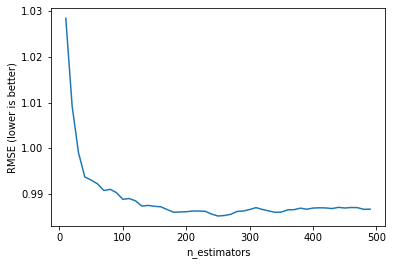

In [364]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

Find the best number of estimators.

In [365]:
sorted(list(zip(RMSE_scores, estimator_range)))[0:10]

#estimator ~250

[(0.9852164297491713, 250),
 (0.9853265781853133, 260),
 (0.9855770177356054, 270),
 (0.9856342385229221, 240),
 (0.9860175279327132, 340),
 (0.9860415396269611, 180),
 (0.9860738214705709, 350),
 (0.9861030663968456, 190),
 (0.9861496429703276, 200),
 (0.9862138781813886, 280)]

The best number of estimators is __250__.

Next, let's narrow down the max number of features. This is the maximum number of features considered during each split in the tree

In [366]:
for i in range(1, 8):
    rfreg = RandomForestRegressor(n_estimators=250,
                              max_features=i,
                              oob_score=True,
                              random_state=33)
    rfreg.fit(X, y)
    print(i)
    print('Cross Validated R-squared:', np.mean(cross_val_score(rfreg, X, y, cv=kf)))
    print('Cross Validated RMSE:', np.sqrt(np.mean(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error'))))


1
Cross Validated R-squared: 0.29908591575537
Cross Validated RMSE: 0.9714038590037718
2
Cross Validated R-squared: 0.3195027311058027
Cross Validated RMSE: 0.957366568819513
3
Cross Validated R-squared: 0.32949816940489
Cross Validated RMSE: 0.9500180081438521
4
Cross Validated R-squared: 0.3327028501975791
Cross Validated RMSE: 0.9479262022449885
5
Cross Validated R-squared: 0.33060651875901004
Cross Validated RMSE: 0.9493630388715455
6
Cross Validated R-squared: 0.3267759248493491
Cross Validated RMSE: 0.9518630870628012
7
Cross Validated R-squared: 0.31847395916378457
Cross Validated RMSE: 0.9578712842244766


The best value for max_features is __4__.

In [367]:
rfreg = RandomForestRegressor(n_estimators=250,
                              max_features=4,
                              oob_score=True,
                              random_state=33)
rfreg.fit(X, y)

RandomForestRegressor(max_features=4, n_estimators=250, oob_score=True,
                      random_state=33)

In [368]:
print('Cross Validated R-squared:', np.mean(cross_val_score(rfreg, X, y, cv=kf)))
print('Cross Validated RMSE:', np.sqrt(np.mean(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error'))))


Cross Validated R-squared: 0.3327028501975791
Cross Validated RMSE: 0.9479262022449885


Looking at the R Squared value for the Random Forest Regressor, we see that it does __much better than linear regression__. However, still fits the model fairly weakly. The RMSE error is ~0.95, which makes it hard to predict the successfulness of the average MLB pitcher (since they typically have a WAR under 1). Yet, it is useful in predicting pitcher's that may exhibit exceptional results (WAR above 1). 

Let's look at the feature importance.

In [369]:
pd.DataFrame({'feature':feature_cols,
              'importance':rfreg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
0,BB/9,0.236990
1,F-Strike%,0.119091
3,avg_fastest_speed,0.117748
9,n_cu,0.094650
2,avg_spin,0.092560
4,n_ff,0.080454
8,n_ch,0.070525
7,n_sl,0.068198
5,n_si,0.057422
6,n_fc,0.035257


As expected the most important feature is BB/9, followed by F-Strike% and how fast the pitcher thorws. The percentage of curveballs thrown is again a shocking result. I'd expect the spin of the baseball to have more importance. 

The hand at which a pitcher throws seems to have little to no importance. Historically, pitchers perform better against batters who swing from the same side they are throwing. Yet, on a macro-scale, the hand a pitcher throws has no influence on their overall WAR. I wonder if this is a consequence of how pitcher's are used or if this is an indication that pitcher handidness collectively does not really matter?

# Summary of Machine Learning Models Tested

__RESULT__: Among the classification algorithms, __logistic regression__ performed the best with cross validation.

__RESULT__: Among the regression algorithms, __random forest regression__ performed the best with cross validation.

I am not sure exactly why the random forest classifier performed much worse than the random forest regressor since the response variable come from the same source (except one is categorical and the other continuous). Is this because WAR is skewed left? 

Another important note is the dominance BB/9 in all models tested. It seems BB/9 is integral to a pitcher's success. Let's try a logistic regression without BB/9 and see if the other features can reject the null hypothesis. 

#### Try removing BB/9 (Logistic Regression)

In [370]:
#remove BB/9 for the new feature columns
feature_cols = ['F-Strike%','avg_spin', 'avg_fastest_speed',  'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'throws']
X = pitching_data[feature_cols]
y = pitching_data['successful']

In [371]:
logreg = LogisticRegression(max_iter=1500, random_state=89)

In [372]:
#5 split cross validation on the dataset
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=40)

print('accuracy:', np.mean(cross_val_score(logreg, X, y, cv=kf, scoring='accuracy')))
print('precision:', np.mean(cross_val_score(logreg, X, y, cv=kf, scoring='precision')))
print('recall:', np.mean(cross_val_score(logreg, X, y, cv=kf, scoring='recall')))

accuracy: 0.6568774233175938
precision: 0.6645173524071557
recall: 0.964207059449721


We see that the accuracy does not reject the null baseline. This shows that BB/9 is the sole feature that pushes the original logistic regression test to beat the baseline. Look below for the baseline (most frequent).

In [373]:
y.value_counts(normalize=True)

1    0.656004
0    0.343996
Name: successful, dtype: float64

Let's look at the confusion matrix to see how the predictions are made.

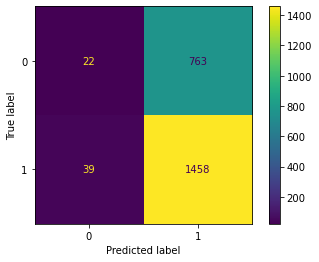

In [374]:
logreg.fit(X, y)
metrics.plot_confusion_matrix(logreg, X, y)

As expected, the model decides to predict pitchers will be successful. To add insult to injury, when the few times the model predicts the pitcher to be unsuccessful, they are actually successful. Therefore, without BB/9, logistic regression does not reject the null hypothesis.

Let's look at feature weights without BB/9.

In [375]:
feature_cols
logreg.coef_[0]
dict(zip(feature_cols, logreg.coef_[0]))

{'F-Strike%': 0.23835532550999874,
 'avg_spin': 0.0007060142553127179,
 'avg_fastest_speed': 0.11421211141649275,
 'n_ff': -0.12561257083903946,
 'n_si': -0.11775299593224373,
 'n_fc': -0.11446508434659763,
 'n_sl': -0.11857486807693624,
 'n_ch': -0.10668711175249752,
 'n_cu': -0.11468781664063328,
 'n_fs': -0.09134803101468382,
 'throws': 0.4686223174268117}

Suprisingly, throws is the most weighted feature. In the random forest regressor, throws was the second least important feature. Maybe this model is inherently flawed in making predictions without BB/9? Let's look at the Random Forest Regressor to see if it can beat the null baseline without BB/9. 

#### Try removing BB/9 (Random Forest Regressor)

In [376]:
#remove BB/9 for the new feature columns and make the response variable continuous
feature_cols = ['F-Strike%','avg_spin', 'avg_fastest_speed',  'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'throws']
X = pitching_data[feature_cols]
y = pitching_data['WAR']

In [377]:
rfreg = RandomForestRegressor(n_estimators=250,
                              max_features=4,
                              oob_score=True,
                              random_state=40)
rfreg.fit(X, y)

RandomForestRegressor(max_features=4, n_estimators=250, oob_score=True,
                      random_state=40)

In [378]:
print('Cross Validated R-squared:', np.mean(cross_val_score(rfreg, X, y, cv=kf)))
print('Cross Validated RMSE:', np.sqrt(np.mean(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error'))))

Cross Validated R-squared: 0.18158323895128753
Cross Validated RMSE: 1.048080102909498


Remember that the baseline (using the mean of pitcher's WAR), had a negative R squared value. This at least somewhat fits the data. In addition, the RMSE is better than the baseline. While, the efficacy of the model takes a huge hit from losing BB/9 as a feature, it still beats the baseline. Therefore, the random forest regressor can make educated decisions without BB/9, giving validity to the other features.

Let's look at the feature importance

In [379]:
pd.DataFrame({'feature':feature_cols,
              'importance':rfreg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
0,F-Strike%,0.181418
2,avg_fastest_speed,0.133429
1,avg_spin,0.120117
8,n_cu,0.112431
3,n_ff,0.110382
6,n_sl,0.094420
7,n_ch,0.090301
4,n_si,0.075815
5,n_fc,0.050597
9,n_fs,0.015586


Unlike logistic regression, throws is the least importnat feature. Everything else makes conceptual sense, as a pitcher's ability to throw a first pitch strike should translate to success. Throwing fast and having a lot of natural spin on the ball should follow in importance. 

Hence, the results here make a lot more sense than the logistic regression results. As a consequence, this problem may be better approached as a regression problem rather than a classification problem. 

__RESULT__: _While it was a good exercise to treat this problem as a classification problem, it may be better to use the Random Forest Regressor as the model to predict pitching success for mlb prospects._

# 5. Predicting Prospects Future

Let's use what we learned so far and make some predictions! We can use the models that best predict the mlb pitching data to predict the WAR of mlb prospects. The data for mlb prospects comes from fangraphs.com. I downloaded csv files directly from the website. 

One csv called (supplementary)_prospect_stats contains information about the performance history of mlb prospects in the minor leagues. Another other contains their scouting data called (supplementary_scouting. The last csv contains summary info on a prospect (height, weight, throwing hand, etc). The three csv files are merged into prospect_data.csv, which is read below.

In [396]:
prospect_data = pd.read_csv('prospect_data.csv') #read the prospect data in from csv to pandas dataframe
prospect_data

,Unnamed: 0,Name,Pos,Org,Top 100,Org Rk,Age_x,TJ Date,FB Type,FB,...,avg_fastest_speed,avg_spin,K/9,IP,BB/9,Age_y,ERA,height,weight,throws
0,0,Grayson Rodriguez,SP,BAL,10.0,2,21.897222,NaN,Tail,60 / 60,...,92.5,2525.0,11.86,113.1,3.90,—,2.461765,"6' 5""",230,R
1,1,D.L. Hall,MIRP,BAL,28.0,3,23.055556,NaN,Tail,60 / 60,...,94.5,2450.0,11.11,175.0,5.50,—,2.725714,"6' 0""",195,L
2,2,Hunter Greene,SP,CIN,34.0,2,22.175000,4/9/2019,Tail,60 / 65,...,96.5,2312.5,11.76,68.1,3.83,—,4.478051,"6' 4""",215,R
3,3,Quinn Priester,SP,PIT,35.0,2,21.066667,NaN,Rise,55 / 55,...,95.5,2325.0,10.19,36.2,4.72,—,3.190906,"6' 3""",210,R
4,4,Sixto Sanchez,SP,MIA,36.0,2,23.194444,NaN,Tail,60 / 60,...,97.0,2250.0,8.31,160.2,2.08,—,2.688796,"6' 0""",234,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,461,Audry Lugo,SIRP,TBR,NaN,51,22.944444,NaN,Cut,45 / 55,...,93.0,2525.0,9.71,38.0,4.26,—,2.131579,"5' 11""",160,R
462,462,Felix Bautista,SIRP,BAL,NaN,47,26.302778,NaN,Tail,65 / 65,...,95.5,NaN,11.11,63.2,5.13,—,3.816752,"6' 5""",220,R
463,463,Will Ethridge,SP,COL,NaN,31,23.802778,NaN,Tail,40 / 40,...,92.5,2175.0,6.26,30.2,2.38,—,3.815213,"6' 5""",220,R
464,464,Antonio Santos,SIRP,COL,NaN,32,25.008333,NaN,Rise,55 / 55,...,93.5,2200.0,8.55,297.0,2.09,—,4.666667,"6' 3""",190,R


### Clean the Prospect Data
Change throws to be machine learning readable. This means converting righties to 0 and lefties to 1.

In [381]:
#check if there are any outliers
prospect_data['throws'].unique()

array(['R', 'L', 'r'], dtype=object)

In [382]:
#since there is an unwanted 'r', let's find it and fix the problem
ind = prospect_data[prospect_data['throws']=='r'].index
prospect_data['throws'].loc[ind[0]] = 'R'
prospect_data['throws'].loc[ind[0]]

C:\Users\605089\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


'R'

In [383]:
#make the categorical data into numbers
prospect_data['throws'].replace({'R': 0, 'L': 1}, inplace=True)

Check if there are any unwanted values for average fastest speed

In [384]:
prospect_data['avg_fastest_speed'].unique() 

array([92.5, 94.5, 96.5, 95.5, 97. , 95. , 93.5, 96. , 93. , 92. , 91.5,
       90. , 91. , 94. , 99.5, 88.5, 87.5, 84.5, 90.5, 89.5, 98. , 89. ,
       97.5, 88. , 86. , 86.5, 98.5])

Check if there are any unwanted values in BB/9

In [385]:
prospect_data['BB/9'].unique() 

array([ 3.9 ,  5.5 ,  3.83,  4.72,  2.08,  4.02,  0.  ,  3.02,  4.14,
        2.9 ,  4.27,  8.21,  4.46,  5.07,  2.3 ,  4.42,  3.72,  2.68,
        2.1 ,  0.5 ,  3.57,  6.98,  1.59,  3.6 ,  3.01,  6.25,  5.54,
        1.09,  4.37,  3.16,  4.93,  1.64,  3.63,  5.84,  5.63,  2.65,
        2.34,  2.61,  5.27,  5.06,  2.44,  3.64,  1.71,  8.01,  6.1 ,
        1.28,  3.85,  4.5 ,  2.25,  2.87,  3.46,  2.51,  5.45,  2.48,
        5.35,  2.47,  3.56,  5.26,  3.17,  8.04,  5.44,  4.26,  2.02,
        1.56,  3.94,  4.17,  5.43,  4.52,  3.58,  5.14,  3.15,  5.18,
        2.98,  5.  ,  4.9 ,  3.61,  2.15,  4.87,  3.26,  6.46,  3.91,
        4.7 ,  5.31,  4.98,  2.6 ,  2.18,  3.  ,  2.85,  6.38, 12.  ,
        5.2 ,  2.32,  1.69,  3.4 ,  0.89,  1.99,  3.07,  3.59,  2.57,
        5.61,  4.3 ,  4.91,  1.76,  8.59,  5.24,  3.79,  5.46,  3.99,
        2.38,  3.55,  8.46,  3.76,  4.13,  3.52,  2.63,  4.57,  1.08,
        1.13,  3.24,  4.09,  4.99,  5.08,  2.84,  4.15,  2.74,  4.41,
        3.97,  1.7 ,

Check if there are any unwanted values for average spin

In [386]:
prospect_data['avg_spin'].unique() 

array([2525. , 2450. , 2312.5, 2325. , 2250. , 2275. , 2225. , 2175. ,
       2400. , 2425. , 2575. , 2550. , 2350. , 2075. , 2375. , 2675. ,
          nan, 2625. , 2500. , 2300. , 2600. , 2650. , 2475. , 2200. ,
       2700. , 2725. , 2150. , 2362.5, 2750. , 2387.5, 2000. , 2100. ,
       2050. , 1725. , 1875. , 2825. , 2125. ])

Drop the nan value in average spin

In [387]:
prospect_data.drop(prospect_data[pd.isna(prospect_data['avg_spin'])].index, inplace=True) 

The information in this dataset does not include all the features used in the Machine Learning section. I do not have information on pitcher's pitch distribution (how many of each pitch is thrown), nor the percentage of first strikes thrown. These are things that would have to be tracked more heavily in the data portion.

In short, let's work with the features that we have.

In [388]:
feature_cols = ['BB/9', 'avg_fastest_speed', 'avg_spin', 'throws']

In [389]:
X = pitching_data[feature_cols]
y = pitching_data['WAR']

### Let's try our regression algorithms. 
Cross validate, choose the best one, run the algorithm across the entire mlb data set, and then predict the prospect data set.

Remember that the features have changed slightly, so we should check how effective the model is still compared to previously.

In [390]:
rfreg = RandomForestRegressor(n_estimators=250,
                              max_features=2,
                              oob_score=True,
                              random_state=40)
rfreg.fit(X, y)

RandomForestRegressor(max_features=2, n_estimators=250, oob_score=True,
                      random_state=40)

In [391]:
print('Cross Validated R-squared:', np.mean(cross_val_score(rfreg, X, y, cv=kf)))
print('Cross Validated RMSE:', np.sqrt(np.mean(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error'))))

Cross Validated R-squared: 0.18782405424053264
Cross Validated RMSE: 1.0434600667591982


We see that by losing a lot of the features, the R-squared value went down significantly. However, we still beat the baseline. The RMSE still states that the error is + or - 1 WAR, so we can use that context when looking at predicted WARs. 

Let's make a prediction using our fitted model on the prospect data.

In [392]:
prospect_data['pred_WAR'] = rfreg.predict(prospect_data[feature_cols])

In [393]:
prospect_data.head()

,Unnamed: 0,Name,Pos,Org,Top 100,Org Rk,Age_x,TJ Date,FB Type,FB,...,avg_spin,K/9,IP,BB/9,Age_y,ERA,height,weight,throws,pred_WAR
0,0,Grayson Rodriguez,SP,BAL,10.0,2,21.897222,NaN,Tail,60 / 60,...,2525.0,11.86,113.1,3.90,—,2.461765,"6' 5""",230,0,0.5496
1,1,D.L. Hall,MIRP,BAL,28.0,3,23.055556,NaN,Tail,60 / 60,...,2450.0,11.11,175.0,5.50,—,2.725714,"6' 0""",195,1,0.0864
2,2,Hunter Greene,SP,CIN,34.0,2,22.175000,4/9/2019,Tail,60 / 65,...,2312.5,11.76,68.1,3.83,—,4.478051,"6' 4""",215,0,1.0124
3,3,Quinn Priester,SP,PIT,35.0,2,21.066667,NaN,Rise,55 / 55,...,2325.0,10.19,36.2,4.72,—,3.190906,"6' 3""",210,0,0.2804
4,4,Sixto Sanchez,SP,MIA,36.0,2,23.194444,NaN,Tail,60 / 60,...,2250.0,8.31,160.2,2.08,—,2.688796,"6' 0""",234,0,2.4708


### Finding Prospects who will be "Successful"

In finding the "successful" pitchers, we need to acknowledge that the WAR has a RMSE of ~1. Therefore, to beat the odds, a pitcher should have a predicted WAR > 1.25. That way, we can account for the error and likely have a successful pitcher. Remember that these are prospects, so we want to go for those that will bring the biggest value in the future.

__ASSUMPTION__: A pitcher with a predicted WAR above 1.25 is one that we think will be successful according to the model

In [394]:
prospect_data.columns

Index(['Unnamed: 0', 'Name', 'Pos', 'Org', 'Top 100', 'Org Rk', 'Age_x',
       'TJ Date', 'FB Type', 'FB', 'SL', 'CB', 'CH', 'CMD', 'RPM FB',
       'RPM Break', 'Sits', 'Tops', 'FV', 'playerId', 'avg_fastest_speed',
       'avg_spin', 'K/9', 'IP', 'BB/9', 'Age_y', 'ERA', 'height', 'weight',
       'throws', 'pred_WAR'],
      dtype='object')

In [395]:
#sort the data by predicted WAR
sorted_prospect_data = prospect_data[['Name', 'pred_WAR', 'throws','avg_fastest_speed', 'avg_spin', 'K/9', 'IP', 'BB/9','ERA']].sort_values(by='pred_WAR', ascending=False)

##filter by pitchers with a predicted WAR greater than 1.25, pitchers who have given up a walk (to show that they are human),
#and pitchers who have pitched at least 50 innings in the minors
sorted_prospect_data[(sorted_prospect_data['pred_WAR'] > 1.25) & 
                     (sorted_prospect_data['BB/9'] != 0) & 
                     (sorted_prospect_data['IP'] > 50)]

,Name,pred_WAR,throws,avg_fastest_speed,avg_spin,K/9,IP,BB/9,ERA
4,Sixto Sanchez,2.4708,0,97.0,2250.0,8.31,160.2,2.08,2.688796
57,Juan Then,1.9828,0,94.5,2425.0,8.26,98.1,2.48,2.837289
272,Alexander Wells,1.8424,1,87.5,2400.0,6.81,272.1,2.18,3.205634
81,Eduard Bazardo,1.6960,0,95.0,2575.0,10.25,151.0,2.15,2.443709
17,Gregory Santos,1.6932,0,95.5,2550.0,7.71,84.1,2.68,3.841894
293,Luis Palacios,1.5904,1,86.0,2250.0,9.00,104.0,0.61,0.951923
107,Jonathan Bowlan,1.5612,0,93.0,2275.0,8.60,181.0,1.99,3.878453
140,Ryan Rolison,1.5336,1,91.5,2425.0,9.34,160.0,2.87,3.937507
16,Jhoan Duran,1.5316,0,97.0,2250.0,10.50,215.2,3.72,3.755795
88,Ronny Henriquez,1.4596,0,94.5,2375.0,11.44,140.0,2.44,3.278571


The list above is the short list of 2021 prospects that are expected to be successful mlb pitchers. Interestingly, Sixto Sanchez has a predicted WAR far above the rest. I can't say that there are many takeaways from this list because the future is truly up for grabs. I can say however, that these pitchers all exhibit a low BB/9.

It's reassuring that other statistics associated with a strong successful pitcher such as ERA (amount of runs a pitcher gives up) is relatively low for all these pitcehrs (typically around 3 or below), despite the fact ERA was never used as a feature in the model.

Additionally, the data was set up such that the index represents their prospect ranking. In other words, Sixto Sanchez is ranked number 4 out of all pitcher prospects according to common consensus. I am not exactly sure how this ranking is made, but it is interesting to see that only 1 of the top 10 pitchers shows up on this list. Conversely, we see pitchers ranked as high as 300 on the list show up on this list. We'll have to see whether this method or the rankings will hold, but only time will tell.

# 6. Conclusion

I was able to take data about mlb pitchers that someone could measure without the presence of an opposing team or batter and use that data to make a prediction about how successful a pitcher will be. The goal was to see if we can approach the scouting process from a machine learning standpoint. While the prediction is weak, it does beat the baseline. 

It is to be noted that the problem has not been entirely answered. As a reminder, the goal of this notebook was to see if we can predict a pitcher's success based off of data that can only be obtained without the presence of a batter. This was assumed to be things like what type of pitches does a pitcher throw, how fast they throw, or how accurate they are. The remaining question mark has mostly to do with accuracy. 

We saw that BB/9, a metric used to evaluate a pitcher's ability to throw strikes when they need to, was the most important feature in evaluating a pitcher's success. However, BB/9 does involve a batter, as it is up to the batter sometimes whether or not take take a ball or swing. Successful pitchers tend to get batters to swing at pitches they don't actually want to swing at. MLB hitters are especially good at laying off pitches that are out of the strikezone. I expect prospect's BB/9 to increase when they reach the major league level. Therefore, I expect this to have an effect on their predicted WAR.

While the other features can somewhat beat the baseline, I am hesitant to say that without BB/9 we can definitely reject the null hypothesis. I would be more at ease if there was another metric to capture accuracy. However, I could not find another that was tracked. One takeaway (if MLB is listening) is to maybe figure out what that metric can be. Technology that can pick up the rotations on a ball can also be applied in other settings, so I'm curious to see if they can develop statistics that tracks a pitcher's ability to throw pitches where they want.

It was a good exercise to try both classification algorithms and regression algorithms. Going forward, I may want to try boosting algorithms such as XGBoost. I also want to try more regression algorithms as I only went between random forest regressor and linear regression. 

A large part of this notebook was determining what features to use. There are still some features that I did EDA on that I didn't end up using (e.g. num pitches, favorite pitch, height, etc.). If I had more time, I would evaluate the efficacy of these features on the different algorithms. From my testing and playing around, the features I ended up using were giving the best results, which is why I ended up going with them.

There are a lot of things that I think I can an improve on going forward. For now, I am satisifed with the practice I got applying machine learning algorithms to real world scenarios.